# Imports libraries and data

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import mritopng
from PIL import Image

import torch

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision.models.vgg import vgg19
import sys
sys.path.append('./Zero-Learning-Fast-Medical-Image-Fusion')
from utils import *

import shutil
import tensorflow as tf

current_path = os.getcwd()
data_path = os.path.join(current_path, 'Data\manifest-MjbMt99Q1553106146386120388')
metadata_path = os.path.join(data_path, 'metadata.csv')
info_path = os.path.join(data_path, 'INFOclinical_STS_csv.csv')
# import data
metadata = pd.read_csv(metadata_path)
info = pd.read_csv(info_path)
import cv2

# Helper Functions

In [3]:
def change_labels(label_list, label_ref):
    """
    This function changes the labels from the predicted labels to the original labels
    :param label_list: list of labels to change
    :param label_ref: list of labels to change to
    :return: list of changed labels
    """
    new_labels = []
    for label in label_list:
        new_label = label_ref[label]
        new_labels.append(new_label)
    return new_labels


# EDA and Metadata Pre-proccessing Before Image Pre-proccessing

In [16]:
info.head()

,Subject ID,MSKCC type,Site of primary STS,Grade,Time - diagnosis to MRI scan (days),Time - MRI scan to PET scan (days),Treatment,"Outcome (recurrence, mets)",Time - diagnosis to outcome (days),"Status (NED, AWD, D)",Time - diagnosis to last follow-up (days)
0,STS_001,Liposarcoma,left thigh,High,-7,4,Radiotherapy + Surgery + Chemotherapy,Mets - arms,266,D,845
1,STS_002,Leiomyosarcoma,left buttock,High,-10,25,Radiotherapy + Surgery,--,--,NED,501
2,STS_003,Other,right buttock,Intermediate,-13,15,Radiotherapy + Surgery,--,--,NED,756
3,STS_004,MFH,right thigh,Low,-6,22,Radiotherapy + Surgery,--,--,NED,1792
4,STS_005,Leiomyosarcoma,left biceps,High,-24,34,Radiotherapy + Surgery,--,--,NED,647


In [17]:
metadata.head()

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
0,1.3.6.1.4.1.14519.5.2.1.5168.1900.169505605471...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,RTstructT1,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,1.05 MB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:17.081
1,1.3.6.1.4.1.14519.5.2.1.5168.1900.236909650266...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,AXIAL SE T1 - RESEARCH,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,40,21.06 MB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:18.905
2,1.3.6.1.4.1.14519.5.2.1.5168.1900.269249420684...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,RTstructT2FS,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,793.95 KB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:20.531
3,1.3.6.1.4.1.14519.5.2.1.5168.1900.267475167888...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.288970202012...,THIGH,09-03-2000,AXIAL SE T2 FAT SAT - RESEARCH,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,40,11.89 MB,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,2022-12-04T15:17:22.271
4,1.3.6.1.4.1.14519.5.2.1.5168.1900.147597676388...,Soft-tissue-Sarcoma,NaN,https://doi.org/10.7937/K9/TCIA.2015.7GO2GSKS,STS_001,1.3.6.1.4.1.14519.5.2.1.5168.1900.980314374925...,PET CT,09-07-2000,RTstructAlignedT1toPET,MIM Software Inc.,RTSTRUCT,RT Structure Set Storage,1.2.840.10008.5.1.4.1.1.481.3,1,1.22 MB,.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...,2022-12-04T15:17:22.541


## Check how many images per modality

,Number of Images
Modality,
CT,13607
MR,10753
PT,13617
RTSTRUCT,306


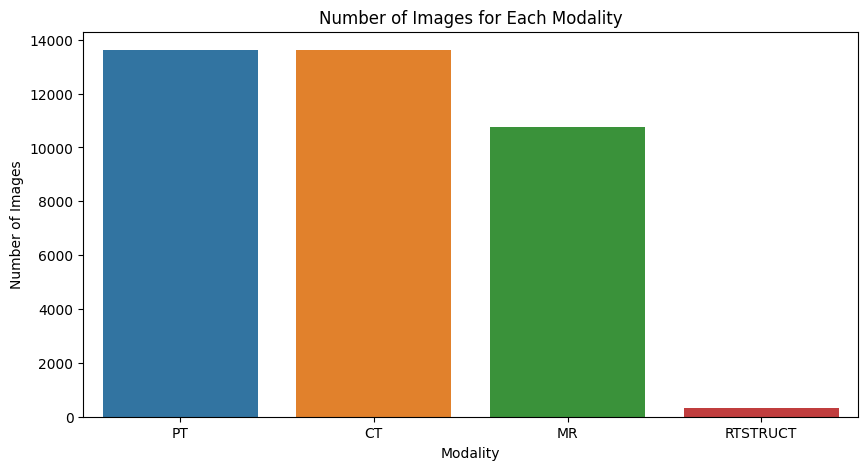

In [18]:
display(metadata[['Number of Images','Modality']].groupby('Modality').sum())
# plot the sum number of images for each modality in ascending order
plt.figure(figsize=(10,5))
sns.barplot(x='Modality', 
            y='Number of Images', 
            data=metadata[['Number of Images','Modality']]
            .groupby('Modality')
            .sum()
            .reset_index()
            .sort_values('Number of Images', ascending=False))
plt.title('Number of Images for Each Modality')
plt.show()

## Check how many subjects per MSKCC type

,Subject ID
MSKCC type,
Extraskeletal bone sarcoma,4
Fibrosarcoma,1
Leiomyosarcoma,10
Liposarcoma,11
MFH,17
Other,3
Synovial sarcoma,5


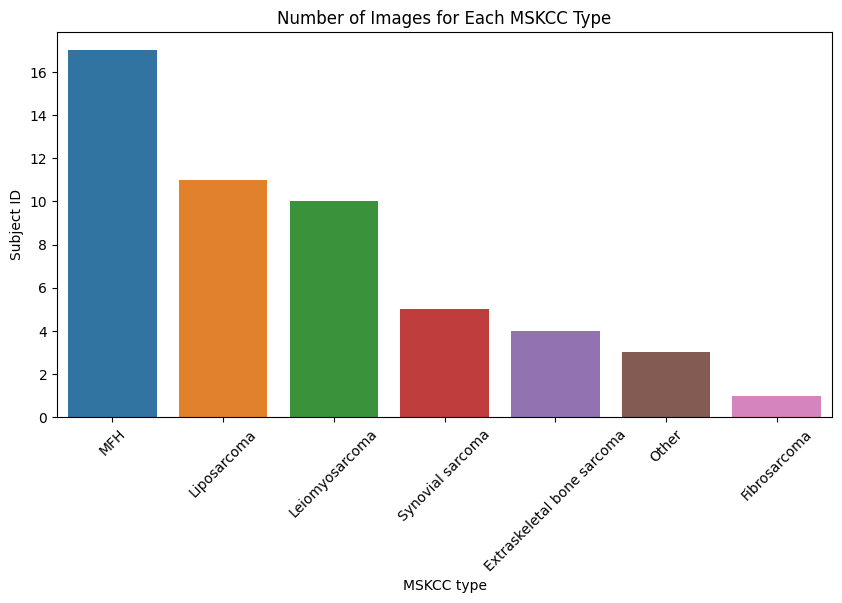

In [19]:
display(info[['Subject ID','MSKCC type']].groupby('MSKCC type').count())
# plot the number of images for each MSKCC type in ascending order
plt.figure(figsize=(10,5))
sns.barplot(x='MSKCC type',
            y='Subject ID',
            data=info[['Subject ID','MSKCC type']]
            .groupby('MSKCC type')
            .count()
            .reset_index()
            .sort_values('Subject ID', ascending=False),)
plt.xticks(rotation=45)
plt.title('Number of Images for Each MSKCC Type')
plt.show()

## Extract relevant columns from both metadataset and join them

In [20]:
meta_extracted = metadata[['Subject ID','Modality','Number of Images', 'File Location','Series Description']]
info_extracted = info[['Subject ID','MSKCC type']]

In [21]:
# join two dataframes
meta_info_join = pd.merge(meta_extracted, info_extracted, on='Subject ID', how='left')

In [22]:
meta_info_join

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type
0,STS_001,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,RTstructT1,Liposarcoma
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma
2,STS_001,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,RTstructT2FS,Liposarcoma
3,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma
4,STS_001,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_001\09-07-2000-NA-PE...,RTstructAlignedT1toPET,Liposarcoma
...,...,...,...,...,...,...
607,STS_051,RTSTRUCT,1,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,RTstructPET,Synovial sarcoma
608,STS_051,CT,267,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,CT IMAGES - LEGS - RESEARCH,Synovial sarcoma
609,STS_051,MR,50,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,AlignedT1toPETBOX,Synovial sarcoma
610,STS_051,MR,52,.\Soft-tissue-Sarcoma\STS_051\11-05-1999-NA-PE...,AlignedT2FStoPETBOX,Synovial sarcoma


## Extract MRI images and non-PETBOX images

In [23]:
# check MR images
meta_info_extracted = meta_info_join[(meta_info_join['Modality'] == 'MR') & (meta_info_join['Series Description'].str.contains('PETBOX') != True)].reset_index(drop=True)
meta_info_extracted

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type
0,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma
2,STS_002,MR,27,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,AXT1,Leiomyosarcoma
3,STS_002,MR,18,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,STIR longTE AX,Leiomyosarcoma
4,STS_003,MR,36,.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MR...,AX STIR,Other
...,...,...,...,...,...,...
97,STS_049,MR,34,.\Soft-tissue-Sarcoma\STS_049\04-14-2002-NA-MR...,Axial FSET1 LOWER TIB FIB - RESEARCH,Liposarcoma
98,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AX STIR,Leiomyosarcoma
99,STS_051,MR,48,.\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...,AXIAL FSE T2 FATSAT - RESEARCH,Synovial sarcoma
100,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AXI T1 FSE - RESEARCH,Leiomyosarcoma


## Add PNG File Location to the metadataset

In [24]:
#  png files location
file_location = meta_info_extracted['File Location'].tolist()
# add png infront of the file location
new_file_location = [x[:21] + '-png' + x[21:] for x in file_location]
meta_info_extracted['PNG File Location'] = new_file_location

## Get rid of STS_029 due to non-matching images

In [25]:
# Get rid of STS_029 due to non-matching images
meta_info_extracted = meta_info_extracted[meta_info_extracted['Subject ID'] != 'STS_029']

In [26]:
meta_info_extracted

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type,PNG File Location
0,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
2,STS_002,MR,27,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,AXT1,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...
3,STS_002,MR,18,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,STIR longTE AX,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...
4,STS_003,MR,36,.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MR...,AX STIR,Other,.\Soft-tissue-Sarcoma-png\STS_003\03-30-2005-N...
...,...,...,...,...,...,...,...
97,STS_049,MR,34,.\Soft-tissue-Sarcoma\STS_049\04-14-2002-NA-MR...,Axial FSET1 LOWER TIB FIB - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_049\04-14-2002-N...
98,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AX STIR,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...
99,STS_051,MR,48,.\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...,AXIAL FSE T2 FATSAT - RESEARCH,Synovial sarcoma,.\Soft-tissue-Sarcoma-png\STS_051\10-24-1999-N...
100,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AXI T1 FSE - RESEARCH,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...


## Check the number of images per each MSKCC type and modality

Number of Images
Modality MSKCC type                                  
MR       MFH                                     1106
         Liposarcoma                              850
         Leiomyosarcoma                           733
         Synovial sarcoma                         342
         Extraskeletal bone sarcoma               284
         Other                                    176
         Fibrosarcoma                             100

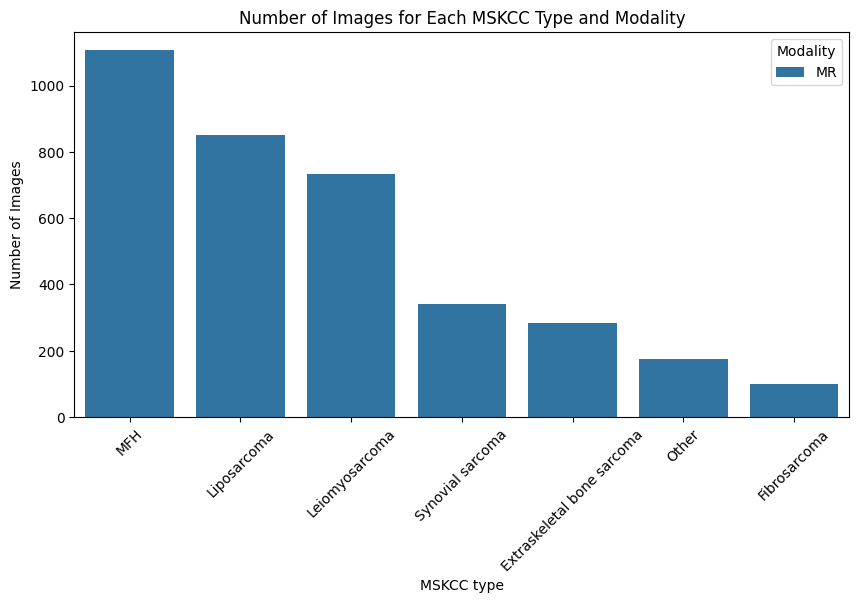

In [27]:
display(meta_info_extracted[['Modality', 'MSKCC type', 'Number of Images']]
 .groupby(['Modality', 'MSKCC type'])
 .sum()
 .sort_values('Number of Images', ascending=False))
#  plot 
plt.figure(figsize=(10,5))
sns.barplot(x='MSKCC type',
            y='Number of Images',
            hue='Modality',
            data=meta_info_extracted[['Modality', 'MSKCC type', 'Number of Images']]
            .groupby(['Modality', 'MSKCC type'])
            .sum()
            .reset_index()
            .sort_values('Number of Images', ascending=False))
plt.xticks(rotation=45)
plt.title('Number of Images for Each MSKCC Type and Modality')
plt.show()

## Checkpoint creation #1

In [40]:
# Checkpoint 1: meta_info_extracted
meta_info_extracted.to_csv('csv_checkpoints\\meta_info_extracted-1.csv', index=False)

# Image Pre-proccessing

## Resume from checkpoint #1

In [42]:
# Restore checkpoint 1
meta_info_extracted = pd.read_csv('csv_checkpoints\\meta_info_extracted-1.csv')

## Convert dicom to png

In [43]:
meta_info_extracted

,Subject ID,Modality,Number of Images,File Location,Series Description,MSKCC type,PNG File Location
0,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T1 - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
1,STS_001,MR,40,.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-TH...,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_001\09-03-2000-N...
2,STS_002,MR,27,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,AXT1,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...
3,STS_002,MR,18,.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-...,STIR longTE AX,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_002\01-03-2006-N...
4,STS_003,MR,36,.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MR...,AX STIR,Other,.\Soft-tissue-Sarcoma-png\STS_003\03-30-2005-N...
...,...,...,...,...,...,...,...
95,STS_049,MR,34,.\Soft-tissue-Sarcoma\STS_049\04-14-2002-NA-MR...,Axial FSET1 LOWER TIB FIB - RESEARCH,Liposarcoma,.\Soft-tissue-Sarcoma-png\STS_049\04-14-2002-N...
96,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AX STIR,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...
97,STS_051,MR,48,.\Soft-tissue-Sarcoma\STS_051\10-24-1999-NA-B ...,AXIAL FSE T2 FATSAT - RESEARCH,Synovial sarcoma,.\Soft-tissue-Sarcoma-png\STS_051\10-24-1999-N...
98,STS_050,MR,30,.\Soft-tissue-Sarcoma\STS_050\01-02-2004-NA-IR...,AXI T1 FSE - RESEARCH,Leiomyosarcoma,.\Soft-tissue-Sarcoma-png\STS_050\01-02-2004-N...


In [44]:
for i in range(len(meta_info_extracted)):
    try:
        mritopng.convert_folder(os.path.join(data_path, meta_info_extracted['File Location'].iloc[i])
                                , os.path.join(data_path, meta_info_extracted['PNG File Location'].iloc[i]))
    except:
        print(meta_info_extracted['File Location'].iloc[i], 'already converted')

.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-THIGH-48623\11.000000-AXIAL SE T1 - RESEARCH-12555 already converted
.\Soft-tissue-Sarcoma\STS_001\09-03-2000-NA-THIGH-48623\10.000000-AXIAL SE T2 FAT SAT - RESEARCH-62438 already converted
.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-SPINE-56934\501.000000-AXT1-02298 already converted
.\Soft-tissue-Sarcoma\STS_002\01-03-2006-NA-L-SPINE-56934\701.000000-STIR longTE AX-10990 already converted
.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MRI PELVIS C- C-15534\4.000000-AX STIR-73168 already converted
.\Soft-tissue-Sarcoma\STS_003\03-30-2005-NA-MRI PELVIS C- C-15534\5.000000-AX T1-51267 already converted
.\Soft-tissue-Sarcoma\STS_004\09-30-1999-NA-RIGHT THIGH C-81525\501.000000-T2ST RT - RESEARCH-20620 already converted
.\Soft-tissue-Sarcoma\STS_004\09-30-1999-NA-RIGHT THIGH C-81525\601.000000-T1 RT - RESEARCH-86077 already converted
.\Soft-tissue-Sarcoma\STS_005\05-29-2005-NA-IRM BRAS GAUCHE C-C-94418\3.000000-AXIALT1-40756 already converted
.\S

## Add Parent Directory to the metadataset

In [45]:
#  save original path
original_path = os.getcwd()

#  add a column that contain the parent directory
meta_info_extracted['Parent Directory'] = meta_info_extracted['PNG File Location'].apply(lambda x: os.path.join(data_path, x))
for i in range(len(meta_info_extracted)):
    #  move up one directory
    os.chdir(meta_info_extracted['Parent Directory'].iloc[i])
    os.chdir('..')
    #  record the child directory into the column
    parent_directory = os.getcwd()
    rel_parent_directory = os.path.relpath(parent_directory, start=data_path)
    meta_info_extracted['Parent Directory'].iloc[i] = ".\\" + rel_parent_directory

#  move back to original directory
os.chdir(original_path)

## M - Cleaned the pictures manually due to extra images that can impact image fusing

## Update file name and remove orignal file column

In [46]:
#  change the word Soft-tissue-Sarcoma-png to Soft-tissue-Sarcoma-png - Manual Cleaning
meta_info_extracted['PNG File Location'] = meta_info_extracted['PNG File Location'].str.replace('Soft-tissue-Sarcoma-png', 'STS - Manual Cleaning')
meta_info_extracted['Parent Directory'] = meta_info_extracted['Parent Directory'].str.replace('Soft-tissue-Sarcoma-png', 'STS - Manual Cleaning')
# remove image file column
meta_info_extracted = meta_info_extracted.drop(columns=['File Location'])

## Update image number

In [47]:
# join png file location with data directory and update number of images based on png files
meta_info_extracted['Number of Images'] = (meta_info_extracted['PNG File Location']
                                      .apply(lambda x: os.path.join(data_path, x))
                                      .apply(lambda x: len(os.listdir(x))))

In [48]:
meta_info_extracted

,Subject ID,Modality,Number of Images,Series Description,MSKCC type,PNG File Location,Parent Directory
0,STS_001,MR,40,AXIAL SE T1 - RESEARCH,Liposarcoma,.\STS - Manual Cleaning\STS_001\09-03-2000-NA-...,.\STS - Manual Cleaning\STS_001\09-03-2000-NA-...
1,STS_001,MR,40,AXIAL SE T2 FAT SAT - RESEARCH,Liposarcoma,.\STS - Manual Cleaning\STS_001\09-03-2000-NA-...,.\STS - Manual Cleaning\STS_001\09-03-2000-NA-...
2,STS_002,MR,15,AXT1,Leiomyosarcoma,.\STS - Manual Cleaning\STS_002\01-03-2006-NA-...,.\STS - Manual Cleaning\STS_002\01-03-2006-NA-...
3,STS_002,MR,15,STIR longTE AX,Leiomyosarcoma,.\STS - Manual Cleaning\STS_002\01-03-2006-NA-...,.\STS - Manual Cleaning\STS_002\01-03-2006-NA-...
4,STS_003,MR,36,AX STIR,Other,.\STS - Manual Cleaning\STS_003\03-30-2005-NA-...,.\STS - Manual Cleaning\STS_003\03-30-2005-NA-...
...,...,...,...,...,...,...,...
95,STS_049,MR,34,Axial FSET1 LOWER TIB FIB - RESEARCH,Liposarcoma,.\STS - Manual Cleaning\STS_049\04-14-2002-NA-...,.\STS - Manual Cleaning\STS_049\04-14-2002-NA-...
96,STS_050,MR,30,AX STIR,Leiomyosarcoma,.\STS - Manual Cleaning\STS_050\01-02-2004-NA-...,.\STS - Manual Cleaning\STS_050\01-02-2004-NA-...
97,STS_051,MR,48,AXIAL FSE T2 FATSAT - RESEARCH,Synovial sarcoma,.\STS - Manual Cleaning\STS_051\10-24-1999-NA-...,.\STS - Manual Cleaning\STS_051\10-24-1999-NA-...
98,STS_050,MR,30,AXI T1 FSE - RESEARCH,Leiomyosarcoma,.\STS - Manual Cleaning\STS_050\01-02-2004-NA-...,.\STS - Manual Cleaning\STS_050\01-02-2004-NA-...


## Checkpoint creation #2

In [49]:
# Checkpoint 2: meta_info_extracted
meta_info_extracted.to_csv('csv_checkpoints\\meta_info_extracted-2.csv', index=False)

## Resizing images

## Resuming from checkpoint #2

In [ ]:
# Restore checkpoint 2
meta_info_extracted = pd.read_csv('csv_checkpoints\\meta_info_extracted-2.csv')

In [51]:
#  for each image in the png file location, resize to 224x224
for i in range(len(meta_info_extracted)):
    # png file location
    png_file_location = os.path.join(data_path, meta_info_extracted['PNG File Location'].iloc[i])
    image_list = os.listdir(png_file_location)
    for image in image_list:
        #  open image
        im = Image.open(os.path.join(png_file_location, image))
        #  resize image
        im = im.resize((224, 224))
        #  save image
        im.save(os.path.join(png_file_location, image))

## Fuse images

In [52]:
# pretrained model
def fuse_images(image_1_path, image_2_path, output_path):
    def imread(image, mode):
        return np.array(Image.open(image).convert(mode))
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    r1, eps1, r2, eps2 = 45, 0.01, 7, 1e-6
    model = vgg19(pretrained=True)
    vgg19_relus = [1, 3, 8]

    # path_to_images = ['images/IV_images/1-38.dcm.png', 'images/IV_images/1-38.dcm - Copy.png']
    path_to_images = [image_1_path, image_2_path]

    imgs = [imread(p, mode='L') for p in path_to_images]

    float_imgs = [(img / 255.).astype(np.float32) for img in imgs]
    bases, details = decompose(float_imgs)

    Wb_0 = sal_weights(imgs)
    Wb_0 = np.moveaxis(Wb_0, -1, 0)  # easier indexed in for-loop
    Wb = guided_optimize(float_imgs, Wb_0, r1, eps1)

    fused_base = weighted_sum(bases, Wb)

    tc_details = stack_to_tensor(details)
    fused_detial = cnn_detail_fusion(tc_details, model, device, relus=vgg19_relus)

    fused = np.clip(fused_base + fused_detial, 0, 1)
    fused = np.rint(fused * 255).astype(np.uint8)
    
    # save image in output path
    im = Image.fromarray(fused)
    im.save(output_path)

In [55]:
# create fuse column and have everything as false
meta_info_extracted['Fuse'] = False
while False in meta_info_extracted['Fuse'].tolist():
    #  check for the first row that is not fused
    first_fuse_row = meta_info_extracted[meta_info_extracted['Fuse'] == False].iloc[0]
    #  check for the rows that has the same parent directory and different png file location
    try:
        second_fuse_row = meta_info_extracted[(meta_info_extracted['Parent Directory'] == first_fuse_row['Parent Directory'])
                                         & (meta_info_extracted['PNG File Location'] != first_fuse_row['PNG File Location'])].iloc[0]
        if second_fuse_row.empty:
            raise Exception('Fuse Rows not found')
    except Exception as e:
        print(str(e))
    
    # fusing operations -------------------------------------------------------------------
    # list of images in the first row
    first_row_images = os.listdir(os.path.join(data_path, first_fuse_row['PNG File Location'][2:]))
    # list of images in the second row
    second_row_images = os.listdir(os.path.join(data_path, second_fuse_row['PNG File Location'][2:]))
    # make directory for fused images
    os.makedirs(os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused'), exist_ok=True)
    for image_index in range(len(first_row_images)):
        image_number = image_index + 1
        image_number = str(image_number).zfill(3)
        fuse_image_name = 'fused-' + image_number + '.png'
        #  fuse the images
        if os.path.exists(os.path.join(data_path, first_fuse_row['PNG File Location'][2:], first_row_images[image_index])) and os.path.exists(os.path.join(data_path, second_fuse_row['PNG File Location'][2:], second_row_images[image_index])):
            # if the fused image does not exist
            if not os.path.exists(os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused', fuse_image_name)):
                fuse_images(os.path.join(data_path, first_fuse_row['PNG File Location'][2:], first_row_images[image_index]),
                            os.path.join(data_path, second_fuse_row['PNG File Location'][2:], second_row_images[image_index]),
                            os.path.join(data_path, first_fuse_row['Parent Directory'], 'fused', fuse_image_name))
    # end of fusing operations ------------------------------------------------------------
    
    #  change fuse to true for every parent directory that has the same parent directory
    meta_info_extracted.loc[meta_info_extracted['Parent Directory'] == first_fuse_row['Parent Directory'], 'Fuse'] = True

#  remove fuse column
meta_info_extracted = meta_info_extracted.drop('Fuse', axis=1)

In [56]:
#  create a new dataframe that contains the parent directory of the fused images
meta_info_fused = meta_info_extracted.drop_duplicates(subset=['Parent Directory'])

meta_info_fused.drop(['PNG File Location', 'Modality'], axis=1, inplace=True)
#  add fused after the parent direcotry
meta_info_fused['Parent Directory'] = meta_info_fused['Parent Directory'] + '\\fused'
# rename parent directory to fused image directory
meta_info_fused.rename(columns={'Parent Directory': 'Fused Image Directory'}, inplace=True)
# update image count based on the number of images in the fused image directory
try:
    for i in range(len(meta_info_fused)):
        meta_info_fused['Number of Images'].iloc[i] = len(os.listdir(os.path.join(data_path, meta_info_fused['Fused Image Directory'].iloc[i][2:])))
except:
    print('Error in updating image count')

## Checkpoint creation #3

In [58]:
#check point 3
meta_info_fused.to_csv( 'csv_checkpoints\\meta_info_fused-3.csv', index=False)

## Resuming from checkpoint #3

In [5]:
# resume from check point 3
meta_info_fused = pd.read_csv('csv_checkpoints\\meta_info_fused-3.csv')

## Number of Images in each MSKCC type after fusing

,Number of Images
MSKCC type,
MFH,547
Liposarcoma,421
Leiomyosarcoma,359
Synovial sarcoma,171
Extraskeletal bone sarcoma,142
Other,88
Fibrosarcoma,50


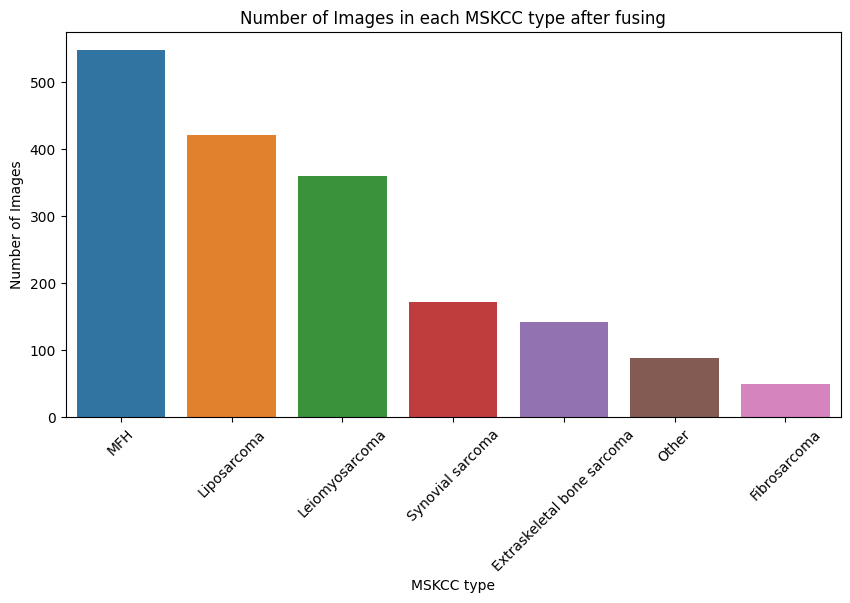

,Number of Images
MSKCC type,
MFH,547
Liposarcoma,421
Leiomyosarcoma,359
Synovial sarcoma,171
Extraskeletal bone sarcoma,142
Other,88
Fibrosarcoma,50


In [30]:
#  count number of images in based on the MSKCC type after fusing
display(meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False))

#  plot
plt.figure(figsize=(10, 5))
sns.barplot(x=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False).index,
            y=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False)['Number of Images'])
plt.xticks(rotation=45)
plt.title('Number of Images in each MSKCC type after fusing')
plt.xlabel('MSKCC type')
plt.ylabel('Number of Images')
plt.show()
display(meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False))

## Combine Fibrosarcoma to Other

In [31]:
# Combine Fibrosarcoma to Other
meta_info_fused.loc[meta_info_fused['MSKCC type'] == 'Fibrosarcoma', 'MSKCC type'] = 'Other'

,Number of Images
MSKCC type,
MFH,547
Liposarcoma,421
Leiomyosarcoma,359
Synovial sarcoma,171
Extraskeletal bone sarcoma,142
Other,138


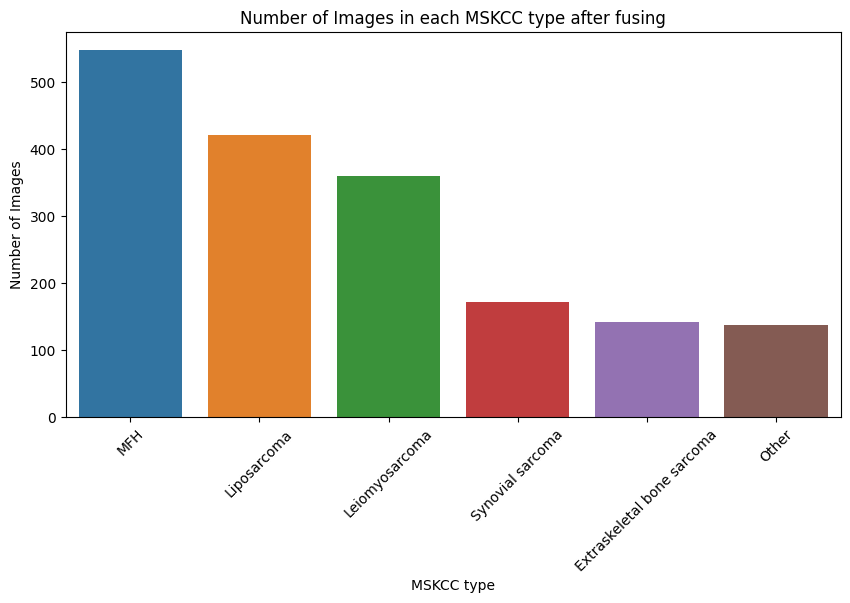

In [49]:
#  count number of images in based on the MSKCC type after fusing
display(meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False))

#  plot
plt.figure(figsize=(10, 5))
sns.barplot(x=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False).index,
            y=meta_info_fused[['MSKCC type', 'Number of Images']].groupby('MSKCC type').sum().sort_values(by='Number of Images', ascending=False)['Number of Images'])
plt.xticks(rotation=45)
plt.title('Number of Images in each MSKCC type after fusing')
plt.xlabel('MSKCC type')
plt.ylabel('Number of Images')
plt.show()

##  Transfer images from their respectve directories to the folder that corresponds to their MSKCC type

In [33]:
#  transfer images from their respectve directories to the folder that corresponds to their MSKCC type
new_data_path = os.path.join(data_path, 'STS-Classes-6')

leiomyosarcoma_index = 1
MFH_index = 1
liposarcoma_index = 1
SS_index = 1
EBS_index = 1
fibrosarcoma_index = 1
other_index = 1

for i in range(len(meta_info_fused)):
    #  create the new directory for the image
    os.makedirs(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i]), exist_ok=True)
    #  get the list of images in the fused image directory
    image_list = os.listdir(os.path.join(data_path, meta_info_fused['Fused Image Directory'].iloc[i][2:]))
    for image in image_list:
        try:
            #  transfer the image to the new directory
            shutil.copy(os.path.join(data_path, meta_info_fused['Fused Image Directory'].iloc[i][2:], image),
                        os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image))
            # rename the image
            if meta_info_fused['MSKCC type'].iloc[i] == 'Leiomyosarcoma':
                # zfill to 4 digits and add the index
                image_number = str(leiomyosarcoma_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Leiomyosarcoma-' + image_number + '.png'))
                leiomyosarcoma_index += 1
            elif meta_info_fused['MSKCC type'].iloc[i] == 'MFH':
                # zfill to 4 digits and add the index
                image_number = str(MFH_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'MFH-' + image_number + '.png'))
                MFH_index += 1
            elif meta_info_fused['MSKCC type'].iloc[i] == 'Liposarcoma':
                # zfill to 4 digits and add the index
                image_number = str(liposarcoma_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Liposarcoma-' + image_number + '.png'))
                liposarcoma_index += 1
            elif meta_info_fused['MSKCC type'].iloc[i] == 'Synovial sarcoma':
                # zfill to 4 digits and add the index
                image_number = str(SS_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Synovial Sarcoma-' + image_number + '.png'))
                SS_index += 1
            elif meta_info_fused['MSKCC type'].iloc[i] == 'Extraskeletal bone sarcoma':
                # zfill to 4 digits and add the index
                image_number = str(EBS_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Extraskeletal Bone Sarcoma-' + image_number + '.png'))
                EBS_index += 1
            elif meta_info_fused['MSKCC type'].iloc[i] == 'Fibrosarcoma':
                # zfill to 4 digits and add the index
                image_number = str(fibrosarcoma_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Fibrosarcoma-' + image_number + '.png'))
                fibrosarcoma_index += 1
            elif meta_info_fused['MSKCC type'].iloc[i] == 'Other':
                # zfill to 4 digits and add the index
                image_number = str(other_index).zfill(4)
                os.rename(os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], image),
                            os.path.join(new_data_path, meta_info_fused['MSKCC type'].iloc[i], 'Other-' + image_number + '.png'))
                other_index += 1           
        except:
            continue

# Deep Learning Model Development

## GPU Check 

In [5]:
# Check for GPU availability
gpu_devices = tf.config.list_physical_devices("GPU")
if gpu_devices:
    for device in gpu_devices:
        print("GPU:", device)
else:
    print("No GPU available.")

# Verify GPU usage in TensorFlow
tf.config.list_physical_devices('GPU')

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Import Libraries define metrics and y columns

In [6]:
#  import train test split
from sklearn.model_selection import train_test_split

#  import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,classification_report, accuracy_score

# for hyperparameter tuning
#  keras tuner random search
from kerastuner.tuners import RandomSearch
#  import HyperModel
from kerastuner import HyperModel

# cross validation
from sklearn.model_selection import StratifiedKFold

# imlearn for oversampling
from imblearn.over_sampling import RandomOverSampler

In [7]:
def microprecision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

In [8]:
def macroprecision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)), axis=0)
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)), axis=0)
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    macro_precision = tf.reduce_mean(precision)
    return macro_precision

In [9]:
# left out: 'Fibrosarcoma'
y_columns = ['Leiomyosarcoma', 'MFH', 'Liposarcoma', 'Synovial sarcoma', 'Extraskeletal bone sarcoma', 'Other']

In [86]:
# setup patiences and overwrite status
PAT = 15
TUNING_PAT =5
OVERWRITE_STATUS = False

## Image dataset preparation

### Create image_df

In [11]:
# import images from the new data path and do train test split, with their directory as their label
new_data_path = os.path.join(data_path, 'STS-Classes-6')
#  get the list of images
image_list = []
label_list = []
for root, dirs, files in os.walk(new_data_path):
    for file in files:
        if file.endswith('.png'):
            image_list.append(os.path.join(root, file))
            label_list.append(root.split('\\')[-1])

#  create a dataframe that contains the image path and their label
image_df = pd.DataFrame({'Image Path': image_list, 'Label': label_list})

# scramble the data random state 42
image_df = image_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
image_df

,Image Path,Label
0,c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...,MFH
1,c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...,Leiomyosarcoma
2,c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...,Other
3,c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...,Liposarcoma
4,c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...,Leiomyosarcoma
...,...,...
1773,c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...,MFH
1774,c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...,MFH
1775,c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...,Liposarcoma
1776,c:\Users\User\Desktop\repo\OVERSAMPLING TEST\S...,MFH


### Train test split

In [13]:
#  split the data into train and test
train_df, test_df = train_test_split(image_df, test_size=0.2, random_state=42, stratify=image_df['Label'])

#  one hot encode the labels
train_df = pd.concat([train_df, pd.get_dummies(train_df['Label'])], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Label'])], axis=1)

In [14]:
# check the distribution of the labels
train_df['Label'].value_counts()

Label
MFH                           437
Liposarcoma                   337
Leiomyosarcoma                287
Synovial sarcoma              137
Extraskeletal bone sarcoma    114
Other                         110
Name: count, dtype: int64

### Resolving class imbalance

In [15]:
# random oversampling
ros = RandomOverSampler(random_state=42)
train_df, _ = ros.fit_resample(train_df, train_df['Label'])   

In [17]:
# check the distribution of the labels
train_df['Label'].value_counts()

Label
Leiomyosarcoma                437
MFH                           437
Other                         437
Liposarcoma                   437
Extraskeletal bone sarcoma    437
Synovial sarcoma              437
Name: count, dtype: int64

### Data Generator with Image Augmentation

In [18]:
#  create the image data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    zoom_range=[0.5, 1.5],
    fill_mode='nearest',
)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
#  create the train, validation and test generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image Path',
    y_col= y_columns,
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image Path',
    y_col= y_columns,
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

train_generator.reset()
test_generator.reset()

Found 2622 validated image filenames.
Found 356 validated image filenames.


##  VGG-16 Model

In [19]:
#  create the model vgg16
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
vgg16.trainable = False

### VGG-16 attempt without hyperparameter tuning

#### Model Building

In [76]:
# create the model
model = tf.keras.models.Sequential([
    vgg16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\VGG-16\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/100
82/82 [==============================] - 29s 352ms/step - loss: 1.7350 - categorical_accuracy: 0.3623 - macroprecision: 0.3354 - microprecision: 0.4607 - val_loss: 1.9907 - val_categorical_accuracy: 0.3904 - val_macroprecision: 0.4394 - val_microprecision: 0.5071
Epoch 2/100
82/82 [==============================] - 26s 311ms/step - loss: 1.3663 - categorical_accuracy: 0.4969 - macroprecision: 0.5349 - microprecision: 0.6091 - val_loss: 1.3022 - val_categorical_accuracy: 0.4382 - val_macroprecision: 0.5302 - val_microprecision: 0.5896
Epoch 3/100
82/82 [==============================] - 25s 307ms/step - loss: 1.2428 - categorical_accuracy: 0.5332 - macroprecision: 0.5999 - microprecision: 0.6267 - val_loss: 1.3050 - val_categorical_accuracy: 0.5281 - val_macroprecision: 0.6113 - val_microprecision: 0.6079
Epoch 4/100
82/82 [==============================] - 25s 309ms/step - loss: 1.1278 - categorical_accuracy: 0.5839 - macroprecision: 0.6553 - microprecision: 0.6855 - val_lo

#### Model claasification report

12/12 [==============================] - 1s 74ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.84      0.96      0.90        28
            Leiomyosarcoma       0.74      0.96      0.84        72
               Liposarcoma       0.84      0.75      0.79        84
                       MFH       0.85      0.65      0.73       110
                     Other       0.90      0.96      0.93        28
          Synovial sarcoma       0.79      0.97      0.87        34

                  accuracy                           0.81       356
                 macro avg       0.83      0.88      0.84       356
              weighted avg       0.82      0.81      0.81       356

Macro Precision:  0.8261063108038914
Micro Precision:  0.8146067415730337


Text(95.7222222222222, 0.5, 'True Labels')

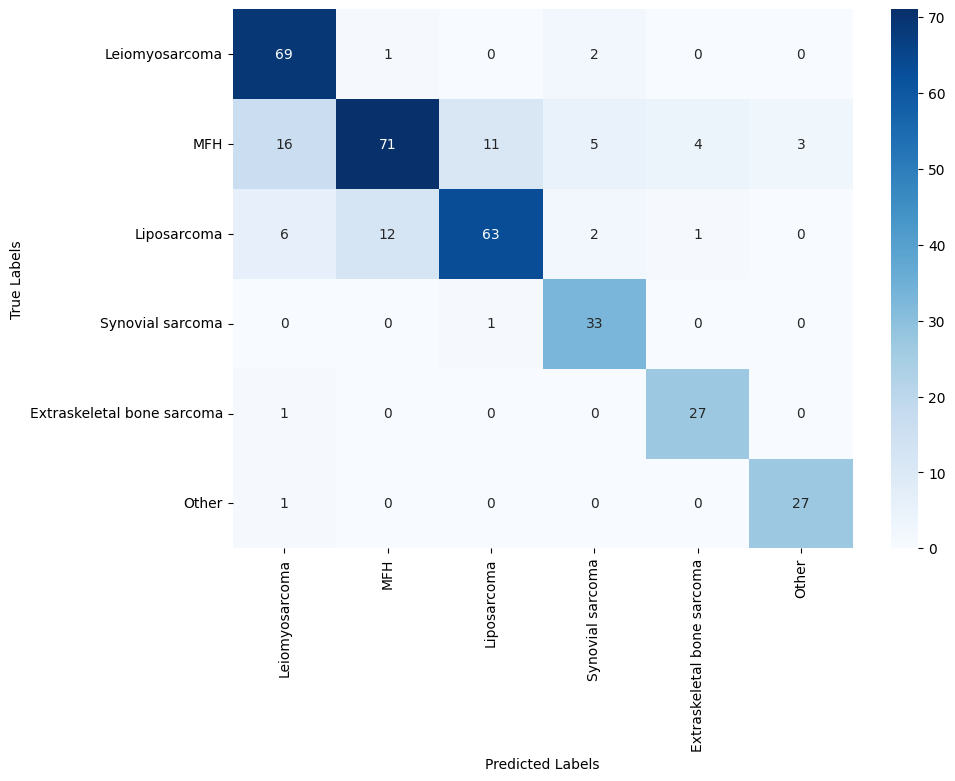

In [81]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

Text(0.5, 1.0, 'Macro Precision')

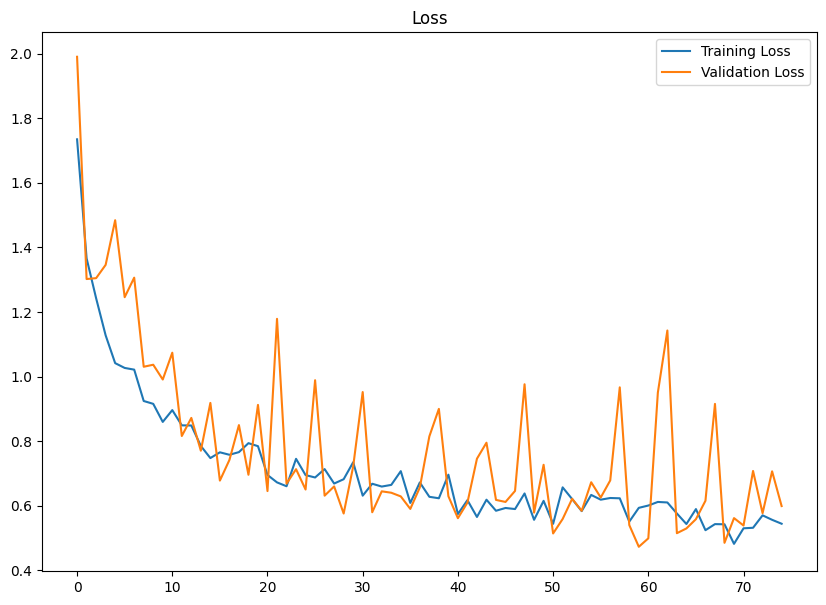

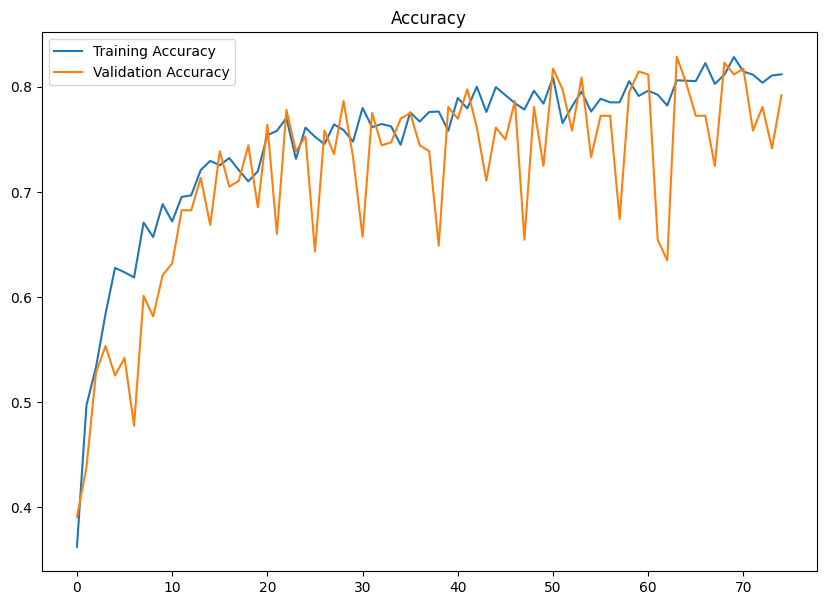

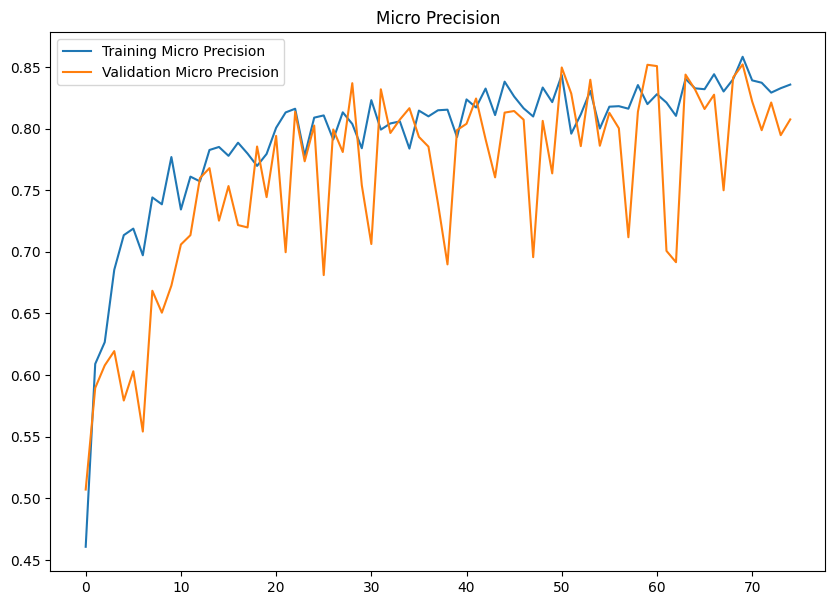

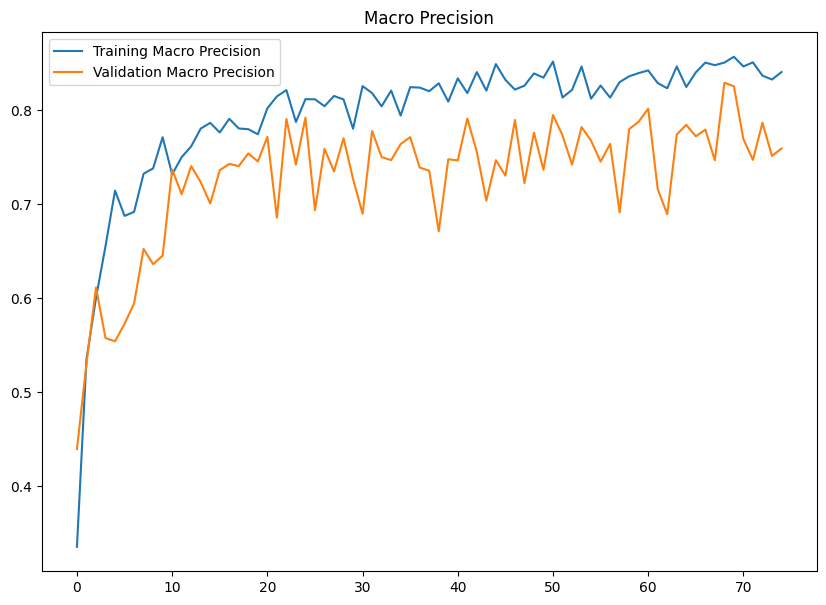

In [82]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [83]:
# save the model
model.save('models\\VGG-16\\vgg-model-test.h5')

### VGG-16 attempt with hyperparameter tuning

#### Define VGG model class

In [24]:
class VGG16Model_class(HyperModel):
    def build(self, hp):
        vgg16 = tf.keras.applications.VGG16(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )
        vgg16.trainable = False
        model = tf.keras.models.Sequential([
            vgg16,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        train_generator.batch_size = hp.Choice("batch_size", [16, 32, 64])
        return model.fit(
            *args,
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [25]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = VGG16Model_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite= OVERWRITE_STATUS,
    directory='models\\VGG-16\\random_search',
    project_name='VGG-16'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = test_generator,
    callbacks=[early_stopping],
)

Trial 50 Complete [00h 12m 58s]
val_loss: 0.8104342818260193

Best val_loss So Far: 0.5809734463691711
Total elapsed time: 11h 01m 55s
INFO:tensorflow:Oracle triggered exit


#### Tuning results

In [26]:
tuner.results_summary()

Results summary
Results in models\VGG-16\random_search\VGG-16
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 39 summary
Hyperparameters:
dropout_rate: 0.1
learning_rate: 0.001
batch_size: 32
epochs: 75
Score: 0.5809734463691711

Trial 15 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.001
batch_size: 16
epochs: 100
Score: 0.6365476548671722

Trial 22 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.001
batch_size: 32
epochs: 100
Score: 0.6887670755386353

Trial 24 summary
Hyperparameters:
dropout_rate: 0.30000000000000004
learning_rate: 0.001
batch_size: 32
epochs: 100
Score: 0.7151570618152618

Trial 34 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.001
batch_size: 32
epochs: 50
Score: 0.7217260897159576

Trial 28 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.001
batch_size: 64
epochs: 75
Score: 0.7517298460006714

Trial 36 summary
Hyperparameters:
dropout_rate: 0.30000000000000004
learning_rate: 0.001
batch_

In [27]:
#  get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

{'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 75}

#### Build the model with the best hyperparameters

##### Model Building

In [28]:
# Build the model with the best hyperparameters
vgg_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\VGG-16\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

train_generator.batch_size = best_hyperparameters.values['batch_size']

#  fit the model
history = vgg_tuned_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs = best_hyperparameters.values['epochs'],
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()

Epoch 1/75
82/82 [==============================] - 24s 285ms/step - loss: 1.6966 - categorical_accuracy: 0.3860 - macroprecision: 0.3566 - microprecision: 0.4980 - val_loss: 1.6101 - val_categorical_accuracy: 0.3904 - val_macroprecision: 0.3358 - val_microprecision: 0.4620
Epoch 2/75
82/82 [==============================] - 23s 278ms/step - loss: 1.3267 - categorical_accuracy: 0.4985 - macroprecision: 0.5472 - microprecision: 0.6215 - val_loss: 1.0802 - val_categorical_accuracy: 0.5393 - val_macroprecision: 0.6533 - val_microprecision: 0.7053
Epoch 3/75
82/82 [==============================] - 23s 276ms/step - loss: 1.2171 - categorical_accuracy: 0.5523 - macroprecision: 0.6169 - microprecision: 0.6557 - val_loss: 1.3457 - val_categorical_accuracy: 0.4747 - val_macroprecision: 0.4824 - val_microprecision: 0.6326
Epoch 4/75
82/82 [==============================] - 23s 275ms/step - loss: 1.0791 - categorical_accuracy: 0.6018 - macroprecision: 0.6785 - microprecision: 0.6984 - val_loss: 

##### Model claasification report

12/12 [==============================] - 1s 62ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.93      0.96      0.95        28
            Leiomyosarcoma       0.91      0.69      0.79        72
               Liposarcoma       0.79      0.88      0.83        84
                       MFH       0.82      0.75      0.79       110
                     Other       0.83      0.89      0.86        28
          Synovial sarcoma       0.66      0.91      0.77        34

                  accuracy                           0.81       356
                 macro avg       0.82      0.85      0.83       356
              weighted avg       0.83      0.81      0.81       356

Micro Precision:  0.8146067415730337
Macro Precision:  0.8236749023398303


Text(95.7222222222222, 0.5, 'True Labels')

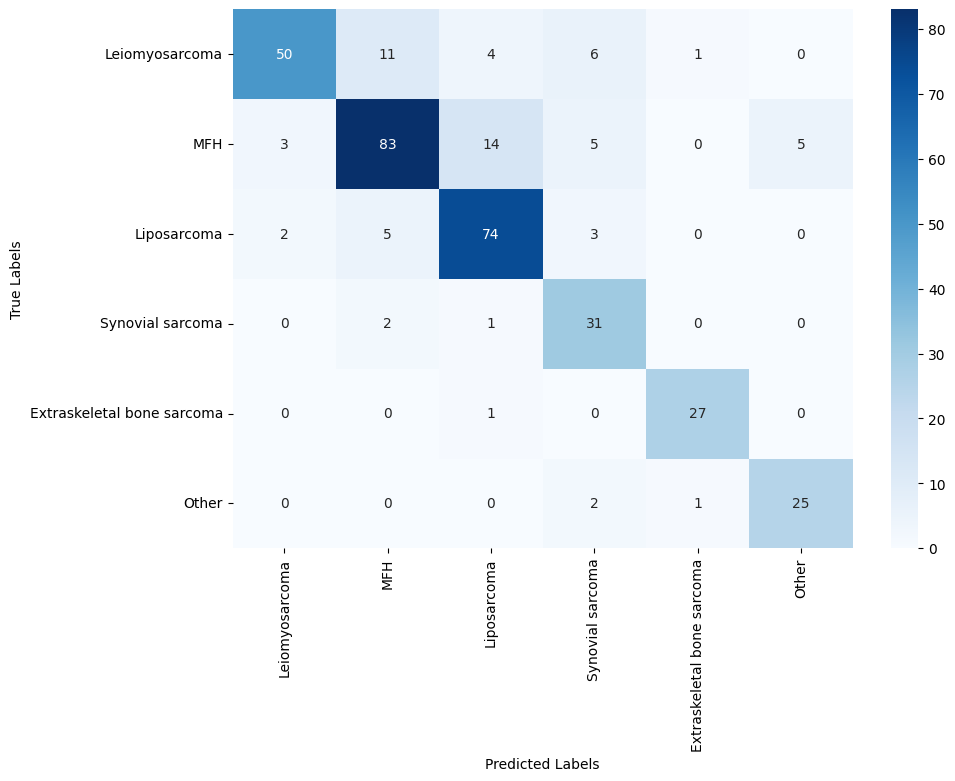

In [29]:
#  evaluate the model
vgg_tuned_model.evaluate(test_generator)

#  predict the test data
predictions = vgg_tuned_model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

# print  macro precision
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', macro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

##### Model History

Text(0.5, 1.0, 'Macro Precision')

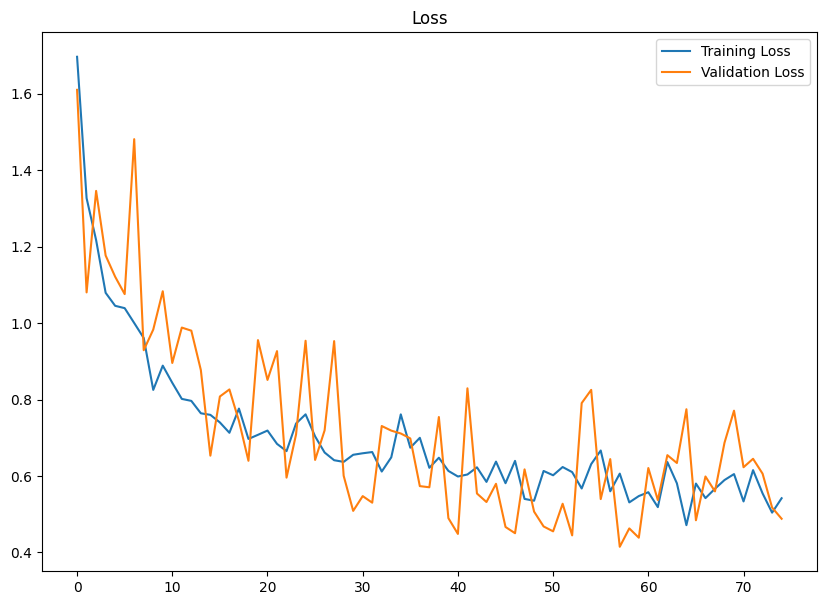

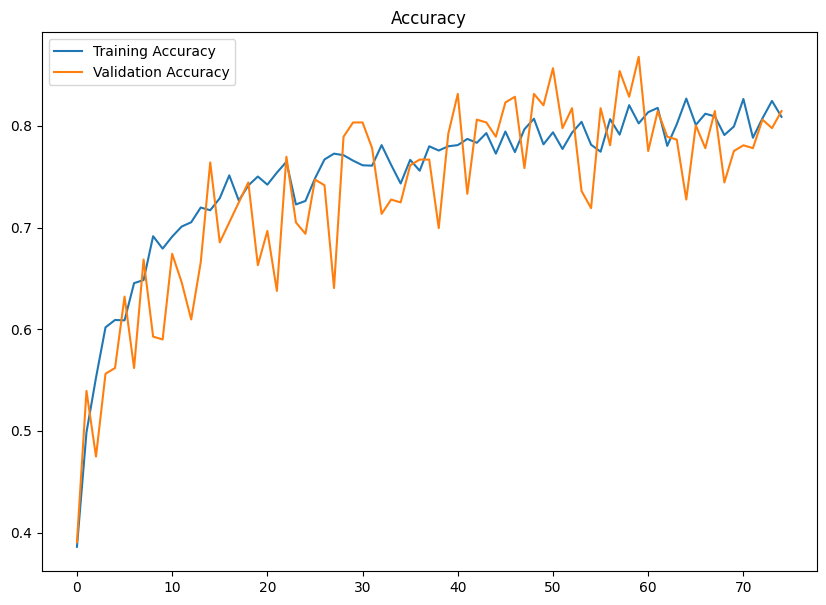

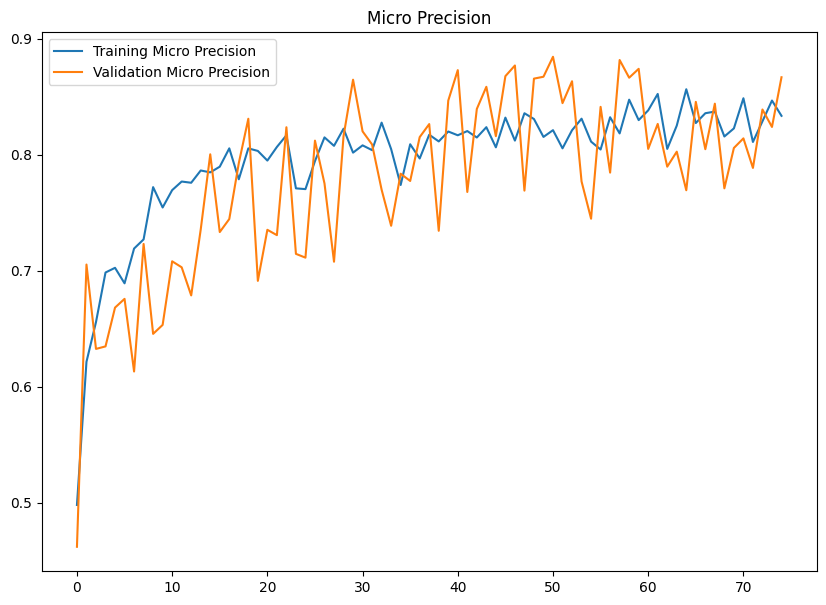

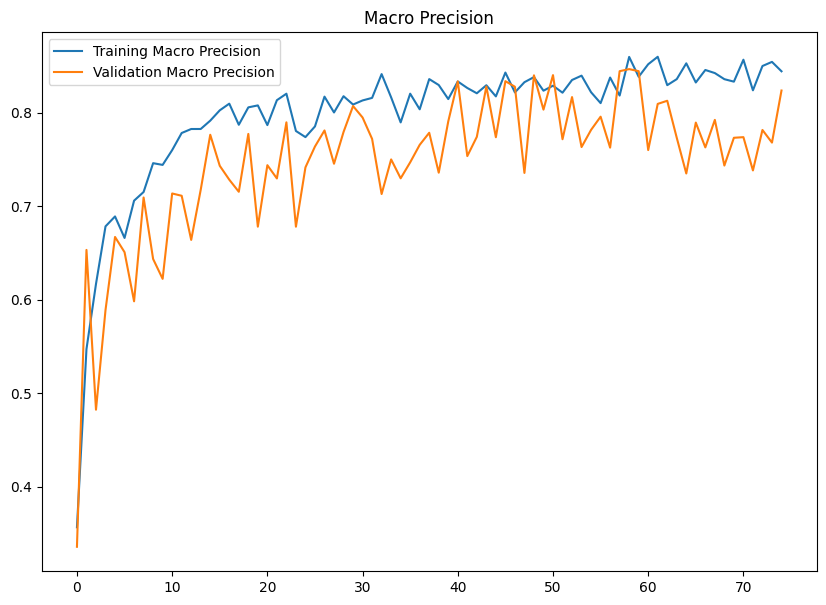

In [30]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [31]:
# save the model
vgg_tuned_model.save('models\\VGG-16\\vgg_tuned_model.h5')

### VGG-16 Cross Validation

In [32]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)

i = 1
vgg_hist = []
vgg_accuracy = []
vgg_micro_precision = []
vgg_macro_precision = []
X = train_df['Image Path']
y = train_df['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\VGG-16\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df.iloc[train_index] 
    test_data_cv  = train_df.iloc[test_index]
    
    train_data_cv, _ = ros.fit_resample(train_data_cv, train_data_cv['Label'])  
    
    train_generator_cv = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size= best_hyperparameters.values['batch_size'],
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator_cv = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    vgg_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    vgg_hist.append(vgg_tuned_model_cv.fit(
        train_generator_cv,
        epochs= best_hyperparameters.values['epochs'],
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator_cv,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    vgg_tuned_model_cv.evaluate(test_generator_cv, verbose=0)
    predictions = vgg_tuned_model_cv.predict(test_generator_cv, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator_cv.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    vgg_accuracy.append(accuracy_score(true_labels, predicted_labels))
    vgg_micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    vgg_macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', vgg_accuracy[i-1], '\nMicro Precision: ', vgg_micro_precision[i-1], '\nMacro Precision: ', vgg_macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(vgg_accuracy))
print('Average micro precision: ', np.mean(vgg_micro_precision))
print('Average macro precision: ', np.mean(vgg_macro_precision))

--------------------------------------------------
Fold  1
--------------------------------------------------
Found 2100 validated image filenames.
Found 525 validated image filenames.

Model 1 evaluation:
Accuracy:  0.8114285714285714 
Micro Precision:  0.8114285714285714 
Macro Precision:  0.8345243755889689


--------------------------------------------------
Fold  2
--------------------------------------------------
Found 2100 validated image filenames.
Found 525 validated image filenames.

Model 2 evaluation:
Accuracy:  0.8495238095238096 
Micro Precision:  0.8495238095238096 
Macro Precision:  0.8528683743235744


--------------------------------------------------
Fold  3
--------------------------------------------------
Found 2100 validated image filenames.
Found 524 validated image filenames.

Model 3 evaluation:
Accuracy:  0.8625954198473282 
Micro Precision:  0.8625954198473282 
Macro Precision:  0.8741295536432995


--------------------------------------------------
Fold  4

## ResNet-50 Model

In [33]:
# change batch size back to 32
train_generator.batch_size = 32

# create restnet model
restnet_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
restnet_model.trainable = False

### ResNet-50 attempt without hyperparameter tuning

#### Model Building

In [34]:
# create the model
model = tf.keras.Sequential([
    restnet_model,
    # tf.keras.layers.GlobalAveragePooling2D(),  
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(6, activation='softmax')
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\RestNet-50\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/100
82/82 [==============================] - 27s 306ms/step - loss: 4.3592 - categorical_accuracy: 0.1895 - macroprecision: 0.0803 - microprecision: 0.1996 - val_loss: 3.0015 - val_categorical_accuracy: 0.1882 - val_macroprecision: 0.1481 - val_microprecision: 0.2206
Epoch 2/100
82/82 [==============================] - 30s 365ms/step - loss: 2.2456 - categorical_accuracy: 0.2494 - macroprecision: 0.1619 - microprecision: 0.3177 - val_loss: 2.8629 - val_categorical_accuracy: 0.1685 - val_macroprecision: 0.1106 - val_microprecision: 0.2174
Epoch 3/100
82/82 [==============================] - 24s 295ms/step - loss: 2.0614 - categorical_accuracy: 0.2551 - macroprecision: 0.2062 - microprecision: 0.3377 - val_loss: 1.9249 - val_categorical_accuracy: 0.3315 - val_macroprecision: 0.2478 - val_microprecision: 0.3770
Epoch 4/100
82/82 [==============================] - 24s 292ms/step - loss: 2.1771 - categorical_accuracy: 0.2593 - macroprecision: 0.2050 - microprecision: 0.3294 - val_lo

#### Model Classifcation Report

12/12 [==============================] - 1s 58ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.48      0.50      0.49        28
            Leiomyosarcoma       0.36      0.67      0.47        72
               Liposarcoma       0.48      0.61      0.53        84
                       MFH       0.76      0.35      0.47       110
                     Other       0.53      0.61      0.57        28
          Synovial sarcoma       1.00      0.15      0.26        34

                  accuracy                           0.49       356
                 macro avg       0.60      0.48      0.47       356
              weighted avg       0.60      0.49      0.48       356

Macro Precision:  0.6019243983912408
Micro Precision:  0.4859550561797753


Text(95.7222222222222, 0.5, 'True Labels')

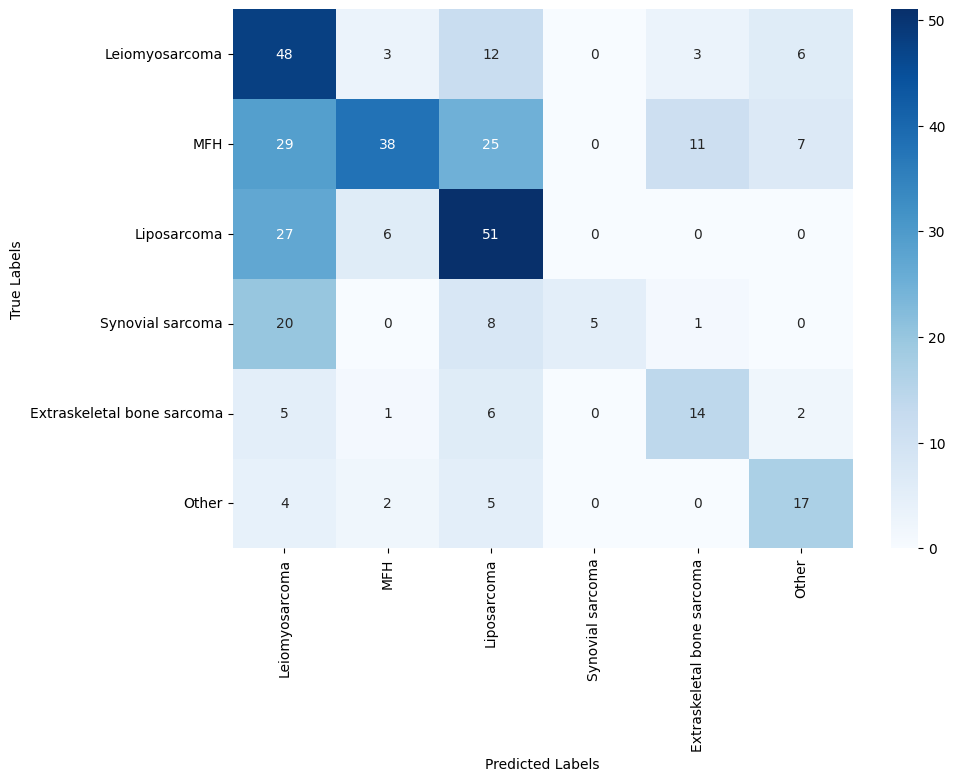

In [35]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

Text(0.5, 1.0, 'Macro Precision')

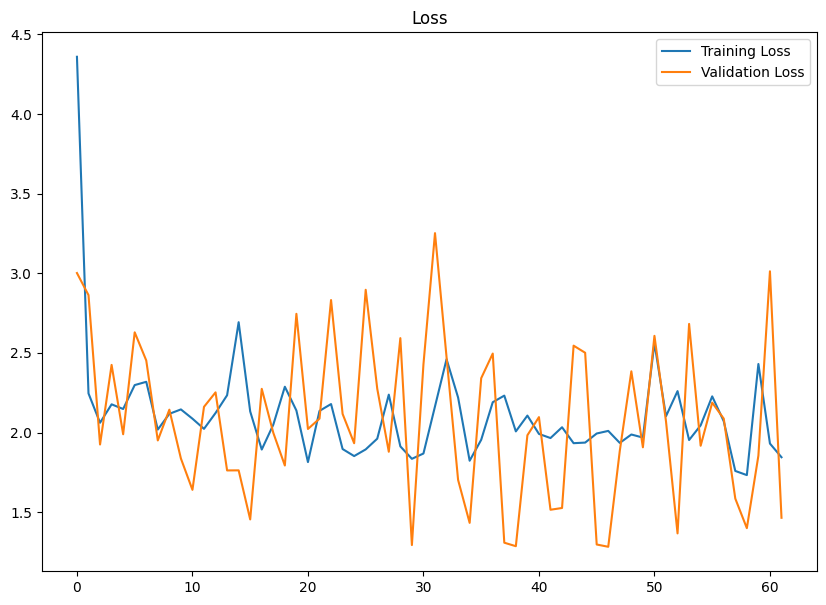

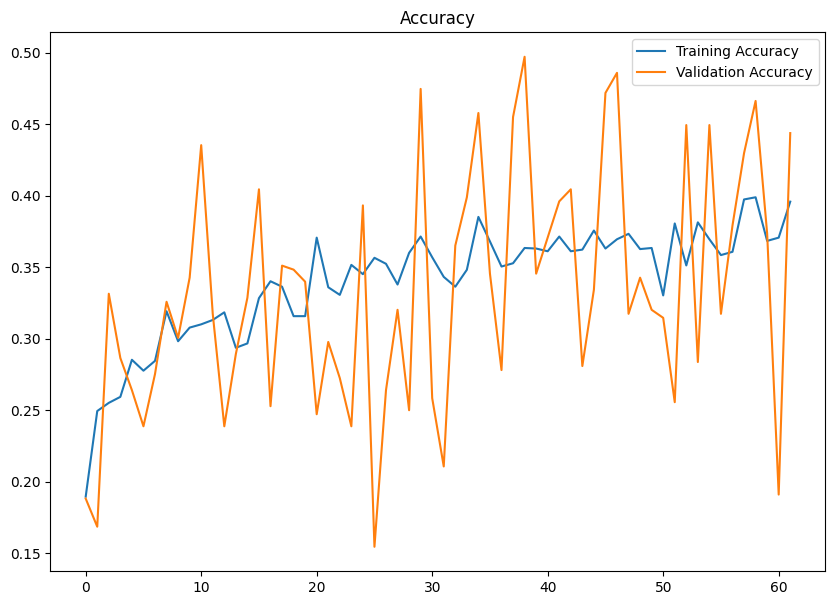

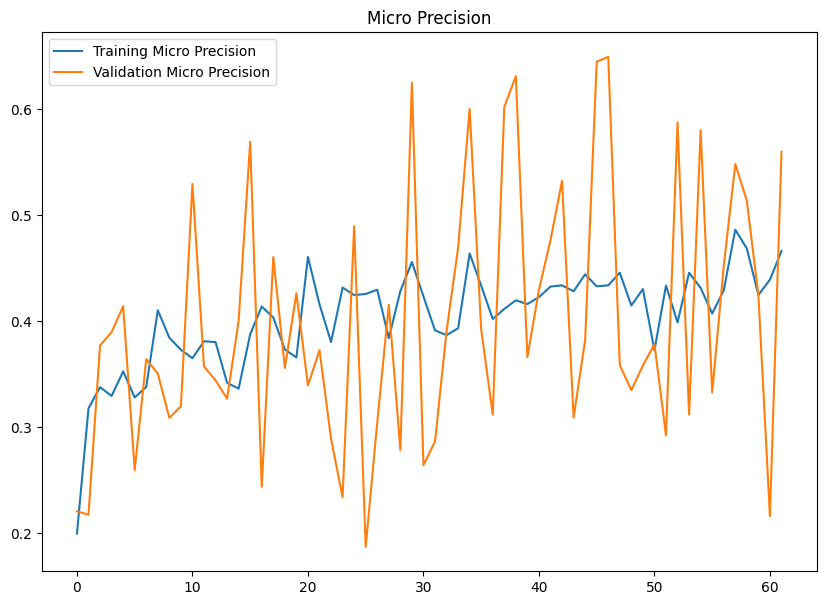

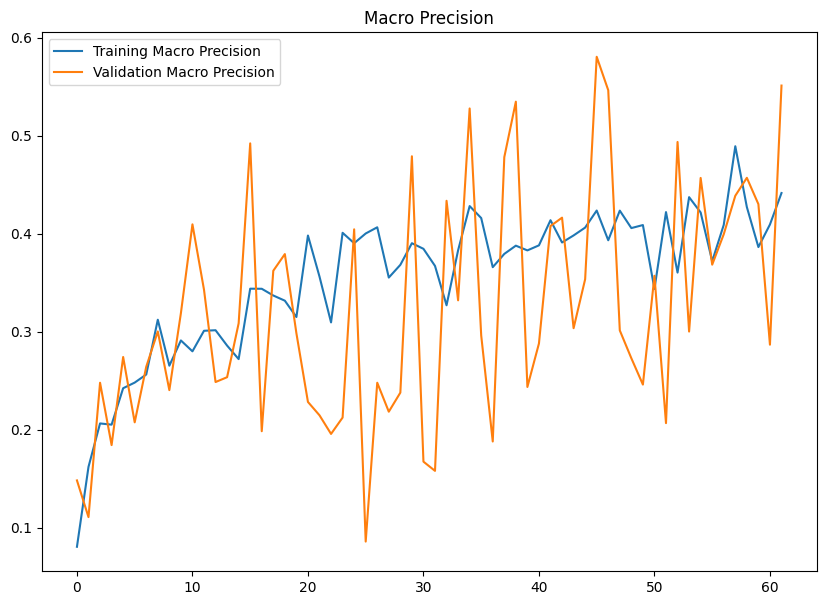

In [36]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Model deem unsuitable for the current dataset, hence no model saving, hyperparameter tuning or cross validation was done

## InceptionV3 Model

In [37]:
# change batch size back to 32
train_generator.batch_size = 32

# create inception model
inception_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
inception_model.trainable = False

### InceptionV3 attempt without hyperparameter tuning

#### Model Building

In [39]:
# create the model
model = tf.keras.models.Sequential([
    inception_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\InceptionV3\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/100
82/82 [==============================] - 28s 307ms/step - loss: 7.6247 - categorical_accuracy: 0.3982 - macroprecision: 0.3885 - microprecision: 0.4061 - val_loss: 2.6065 - val_categorical_accuracy: 0.4663 - val_macroprecision: 0.4233 - val_microprecision: 0.4855
Epoch 2/100
82/82 [==============================] - 24s 289ms/step - loss: 2.3889 - categorical_accuracy: 0.5877 - macroprecision: 0.6208 - microprecision: 0.5982 - val_loss: 2.5057 - val_categorical_accuracy: 0.5309 - val_macroprecision: 0.5562 - val_microprecision: 0.5461
Epoch 3/100
82/82 [==============================] - 23s 285ms/step - loss: 2.3147 - categorical_accuracy: 0.6259 - macroprecision: 0.6437 - microprecision: 0.6334 - val_loss: 3.3701 - val_categorical_accuracy: 0.5253 - val_macroprecision: 0.5562 - val_microprecision: 0.5300
Epoch 4/100
82/82 [==============================] - 23s 279ms/step - loss: 2.0728 - categorical_accuracy: 0.6598 - macroprecision: 0.6813 - microprecision: 0.6665 - val_lo

#### Model Classification Report

12/12 [==============================] - 2s 55ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.72      0.82      0.77        28
            Leiomyosarcoma       0.73      0.72      0.73        72
               Liposarcoma       0.77      0.82      0.79        84
                       MFH       0.85      0.65      0.74       110
                     Other       0.79      0.93      0.85        28
          Synovial sarcoma       0.60      0.79      0.68        34

                  accuracy                           0.76       356
                 macro avg       0.74      0.79      0.76       356
              weighted avg       0.77      0.76      0.76       356

Macro Precision:  0.7421247740453415
Micro Precision:  0.7556179775280899


Text(95.7222222222222, 0.5, 'True Labels')

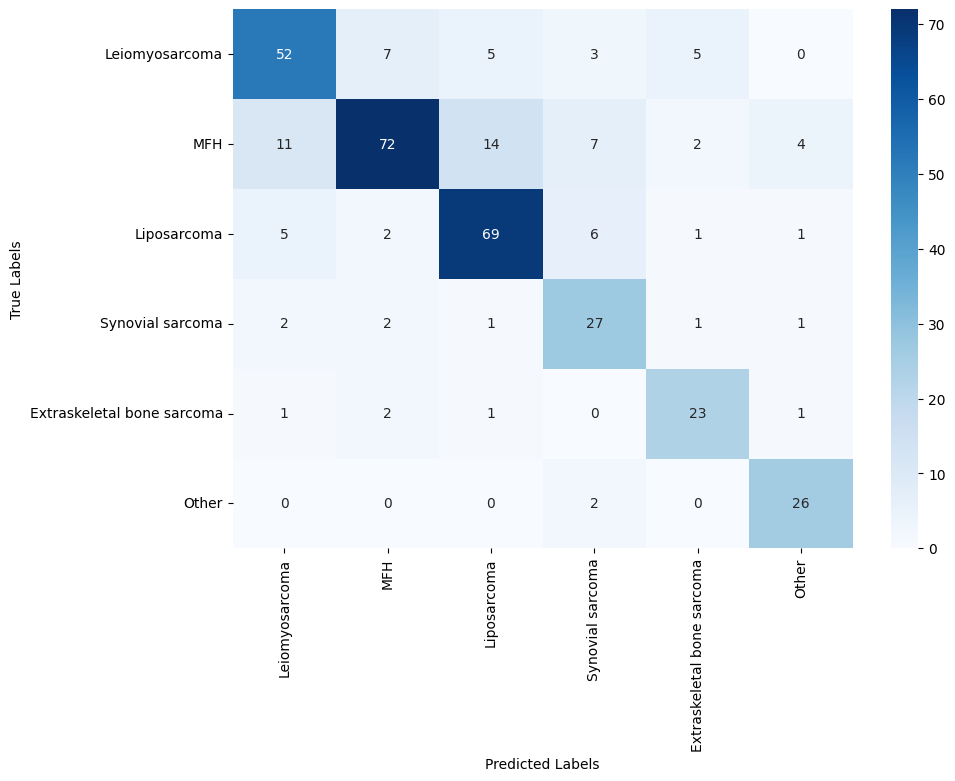

In [40]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

Text(0.5, 1.0, 'Macro Precision')

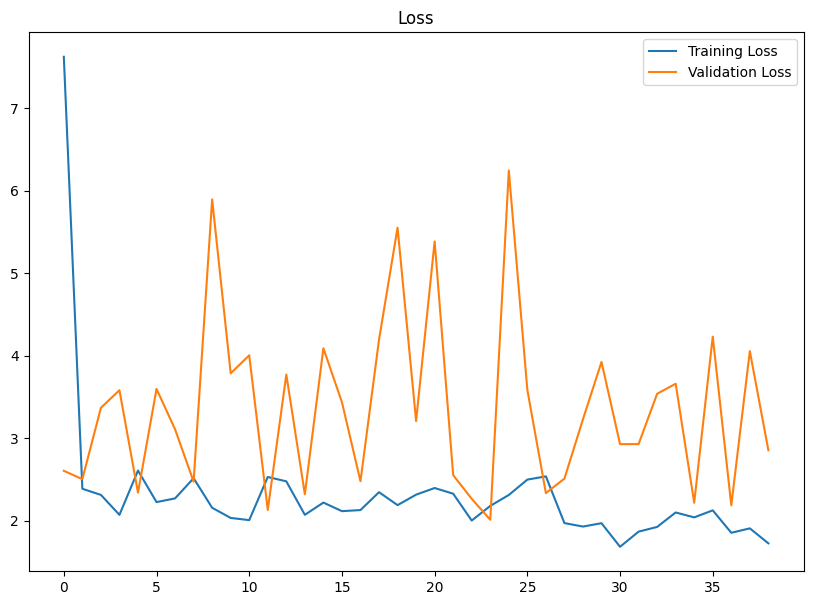

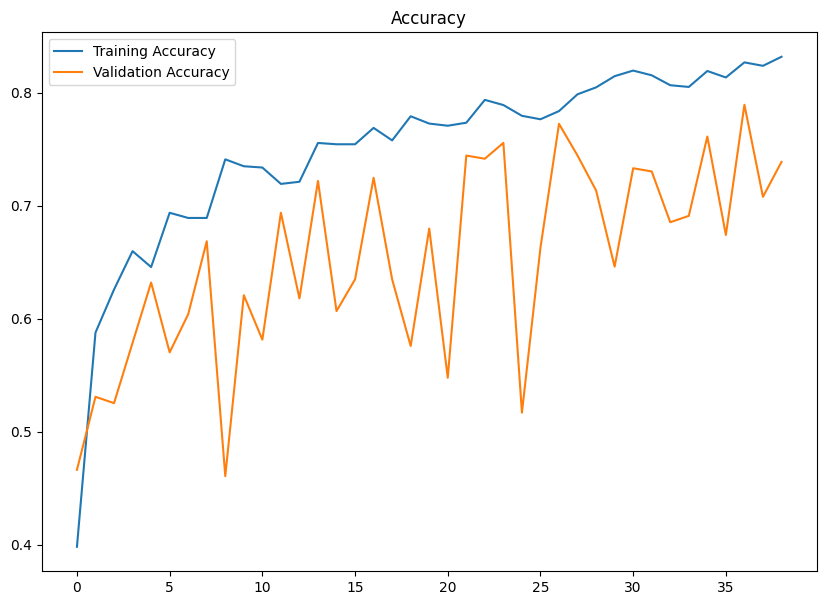

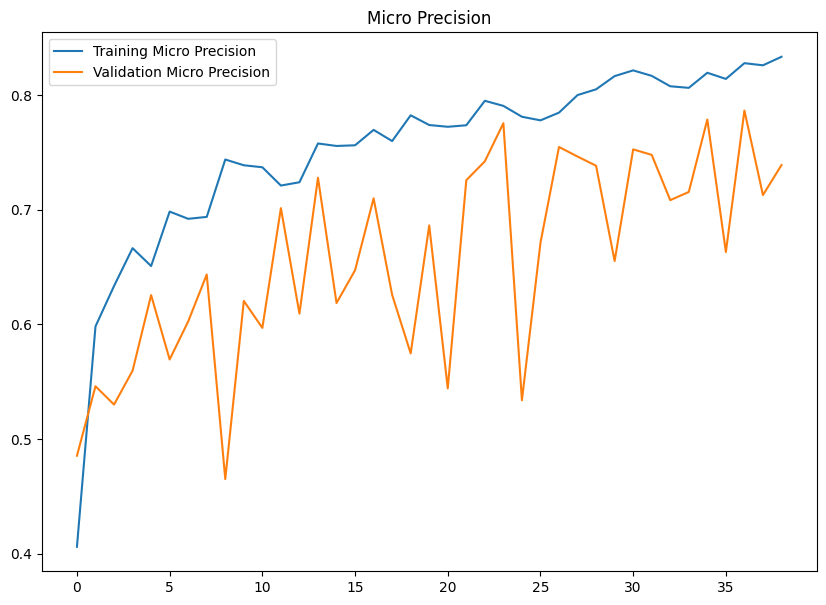

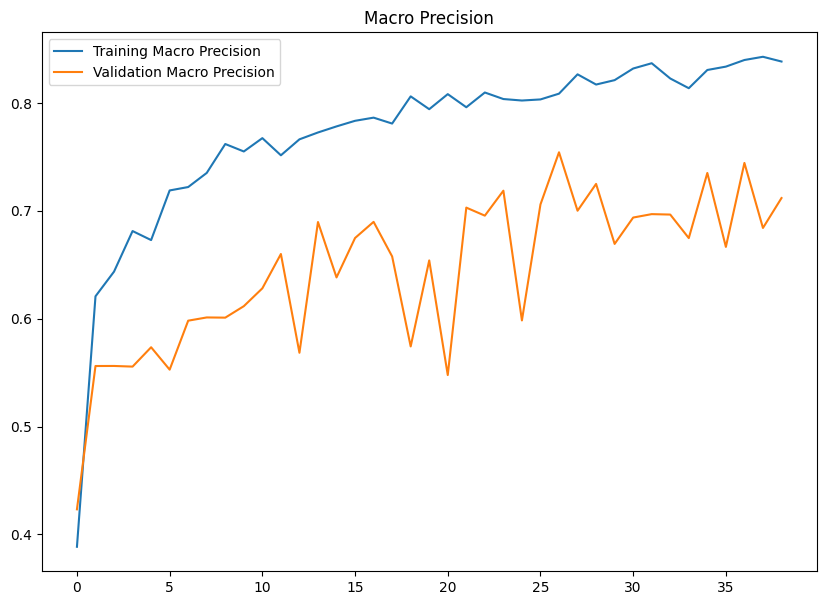

In [41]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [42]:
# save the model
model.save('models\\InceptionV3\\inception-model-test.h5')

### InceptionV3 attempt with hyperparameter tuning

#### Define InceptionV3 model class

In [43]:
class InceptionV3Model_class(HyperModel):
    def build(self, hp):
        inception_model = tf.keras.applications.InceptionV3(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )

        #  freeze the layers
        inception_model.trainable = False
        model = tf.keras.models.Sequential([
            inception_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        train_generator.batch_size = hp.Choice("batch_size", [16, 32, 64])
        return model.fit(
            *args,
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [44]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = InceptionV3Model_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite= OVERWRITE_STATUS,
    directory='models\\InceptionV3\\random_search',
    project_name='InceptionV3'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = test_generator,
    callbacks=[early_stopping],
)

Trial 50 Complete [00h 07m 04s]
val_loss: 3.2257601022720337

Best val_loss So Far: 0.5731295049190521
Total elapsed time: 09h 06m 05s
INFO:tensorflow:Oracle triggered exit


In [45]:
tuner.results_summary()

Results summary
Results in models\InceptionV3\random_search\InceptionV3
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 20 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size: 32
epochs: 50
Score: 0.5731295049190521

Trial 33 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.0001
batch_size: 64
epochs: 100
Score: 0.5878642797470093

Trial 09 summary
Hyperparameters:
dropout_rate: 0.1
learning_rate: 0.0001
batch_size: 64
epochs: 50
Score: 0.614630788564682

Trial 13 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.0001
batch_size: 32
epochs: 100
Score: 0.6244069635868073

Trial 45 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size: 32
epochs: 100
Score: 0.6407687067985535

Trial 16 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size: 64
epochs: 50
Score: 0.6410213708877563

Trial 42 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.0001
batch_size: 32
epochs:

In [46]:
#  get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

{'dropout_rate': 0.4, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 50}

#### Build the model with the best hyperparameters

##### Model Building

In [47]:
# Build the model with the best hyperparameters
inception_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\InceptionV3\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

train_generator.batch_size = best_hyperparameters.values['batch_size']

#  fit the model
history = inception_tuned_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs= best_hyperparameters.values['epochs'],
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()

Epoch 1/50
82/82 [==============================] - 26s 288ms/step - loss: 2.0927 - categorical_accuracy: 0.3471 - macroprecision: 0.3606 - microprecision: 0.3798 - val_loss: 1.4866 - val_categorical_accuracy: 0.4466 - val_macroprecision: 0.4576 - val_microprecision: 0.4749
Epoch 2/50
82/82 [==============================] - 22s 271ms/step - loss: 1.5339 - categorical_accuracy: 0.4958 - macroprecision: 0.5322 - microprecision: 0.5426 - val_loss: 1.6097 - val_categorical_accuracy: 0.4691 - val_macroprecision: 0.5768 - val_microprecision: 0.5397
Epoch 3/50
82/82 [==============================] - 23s 275ms/step - loss: 1.3036 - categorical_accuracy: 0.5591 - macroprecision: 0.6054 - microprecision: 0.6224 - val_loss: 1.2186 - val_categorical_accuracy: 0.5534 - val_macroprecision: 0.6044 - val_microprecision: 0.6463
Epoch 4/50
82/82 [==============================] - 23s 274ms/step - loss: 1.2142 - categorical_accuracy: 0.5866 - macroprecision: 0.6376 - microprecision: 0.6353 - val_loss: 

##### Model Classification Report

12/12 [==============================] - 1s 49ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.84      0.93      0.88        28
            Leiomyosarcoma       0.86      0.75      0.80        72
               Liposarcoma       0.78      0.82      0.80        84
                       MFH       0.88      0.77      0.82       110
                     Other       0.87      0.96      0.92        28
          Synovial sarcoma       0.63      0.85      0.72        34

                  accuracy                           0.81       356
                 macro avg       0.81      0.85      0.82       356
              weighted avg       0.82      0.81      0.82       356

Micro Precision:  0.8146067415730337
Macro Precision:  0.8096057713318524


Text(95.7222222222222, 0.5, 'True Labels')

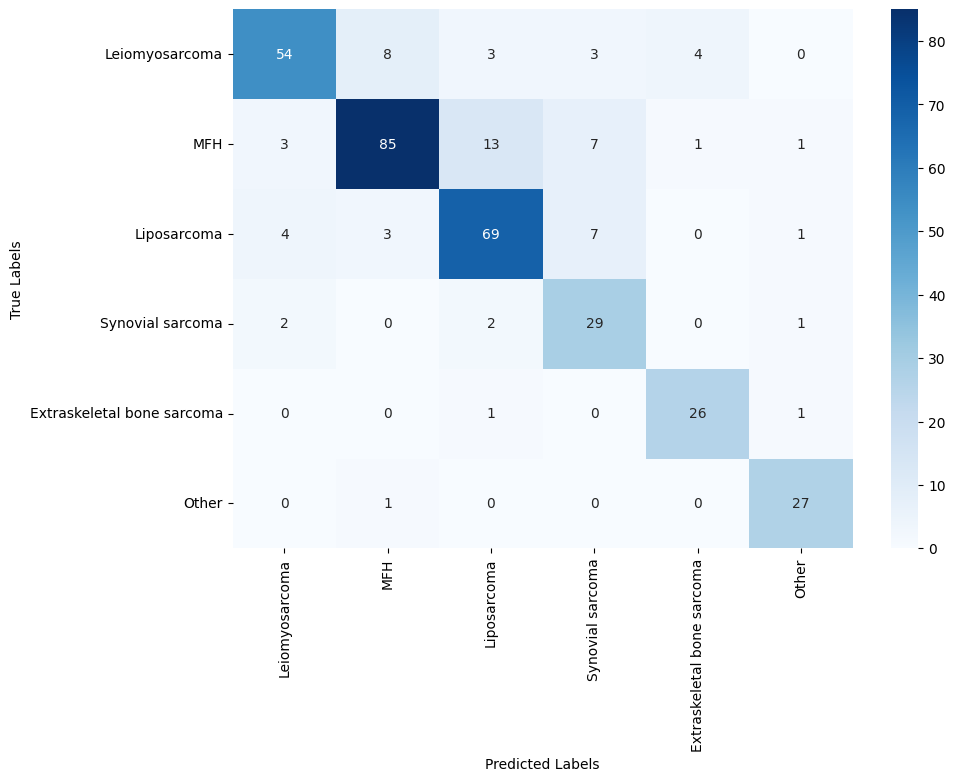

In [48]:
#  evaluate the model
inception_tuned_model.evaluate(test_generator)

#  predict the test data
predictions = inception_tuned_model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

# print  macro precision
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', macro_precision)

# get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

##### Model History

Text(0.5, 1.0, 'Macro Precision')

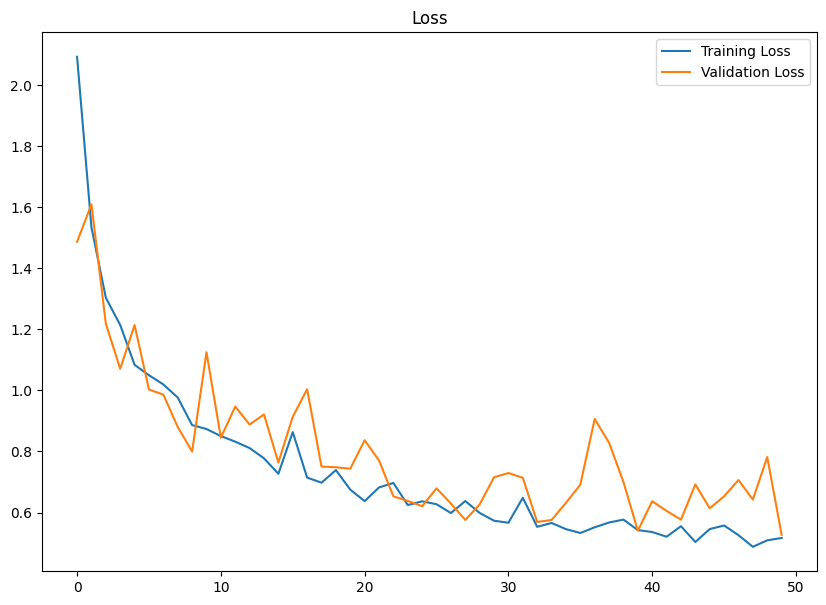

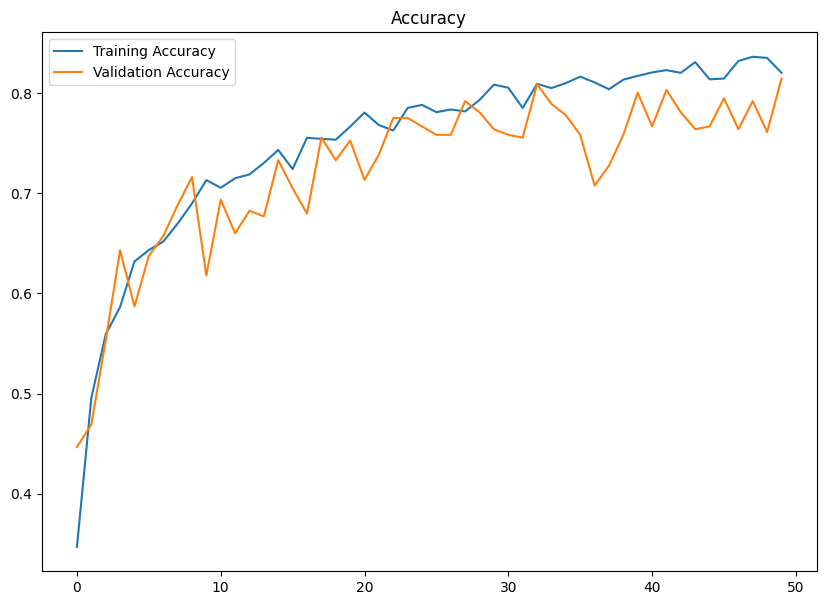

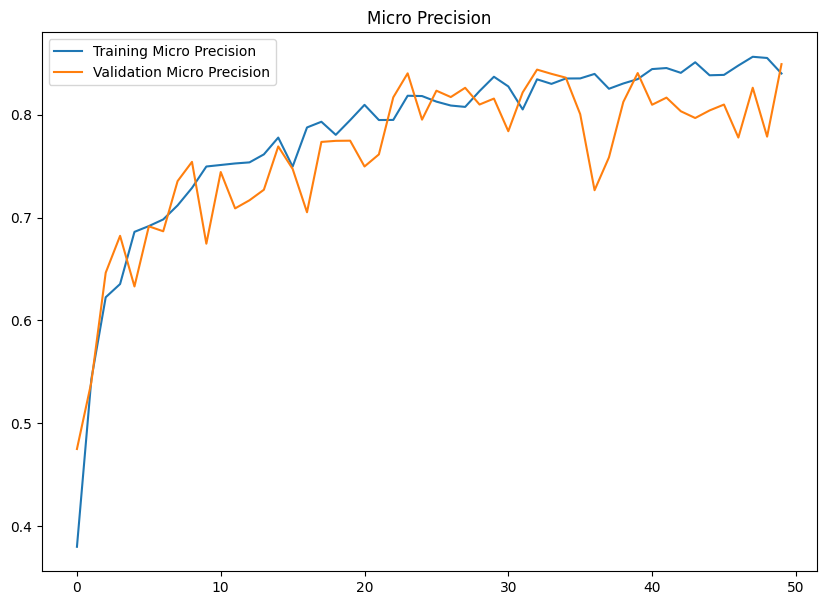

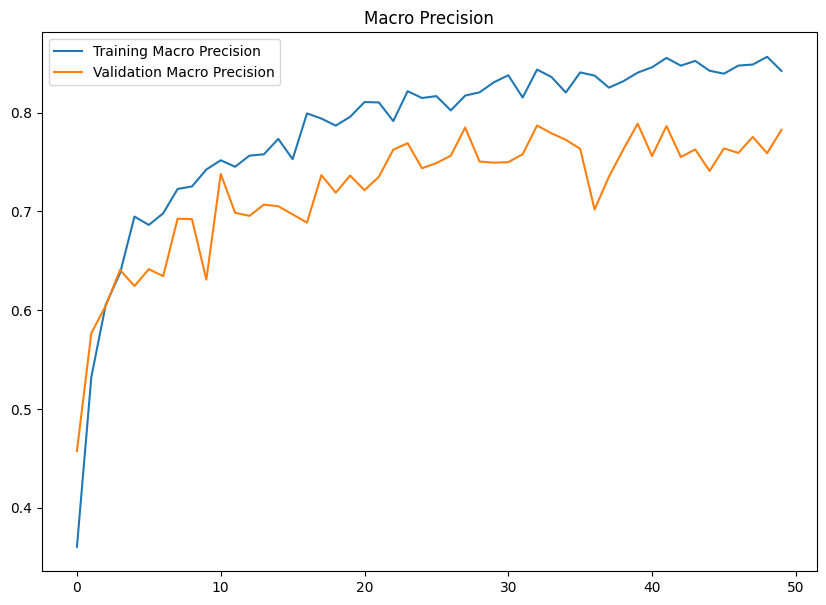

In [49]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [50]:
#  save the model
inception_tuned_model.save('models\\InceptionV3\\inception-model-tuned.h5')

### InceptionV3 Cross Validation

In [51]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
i = 1
incep_hist = []
incep_accuracy = []
incep_micro_precision = []
incep_macro_precision = []
X = train_df['Image Path']
y = train_df['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\InceptionV3\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df.iloc[train_index]
    test_data_cv  = train_df.iloc[test_index]
    
    train_data_cv, _ = ros.fit_resample(train_data_cv, train_data_cv['Label'])  
    
    train_generator_cv = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=best_hyperparameters.values['batch_size'],
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator_cv = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    inception_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    incep_hist.append(inception_tuned_model_cv.fit(
        train_generator_cv,
        epochs=best_hyperparameters.values['epochs'],
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator_cv,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    inception_tuned_model_cv.evaluate(test_generator_cv, verbose=0)
    predictions = inception_tuned_model_cv.predict(test_generator_cv, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator_cv.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    incep_accuracy.append(accuracy_score(true_labels, predicted_labels))
    incep_micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    incep_macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', incep_accuracy[i-1], '\nMicro Precision: ', incep_micro_precision[i-1], '\nMacro Precision: ', incep_macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(incep_accuracy))
print('Average micro precision: ', np.mean(incep_micro_precision))
print('Average macro precision: ', np.mean(incep_macro_precision))

--------------------------------------------------
Fold  1
--------------------------------------------------
Found 2100 validated image filenames.
Found 525 validated image filenames.

Model 1 evaluation:
Accuracy:  0.820952380952381 
Micro Precision:  0.820952380952381 
Macro Precision:  0.8412183183281224


--------------------------------------------------
Fold  2
--------------------------------------------------
Found 2100 validated image filenames.
Found 525 validated image filenames.

Model 2 evaluation:
Accuracy:  0.8571428571428571 
Micro Precision:  0.8571428571428571 
Macro Precision:  0.8623417082379562


--------------------------------------------------
Fold  3
--------------------------------------------------
Found 2100 validated image filenames.
Found 524 validated image filenames.

Model 3 evaluation:
Accuracy:  0.8435114503816794 
Micro Precision:  0.8435114503816794 
Macro Precision:  0.8474772383171242


--------------------------------------------------
Fold  4
-

## EfficientNet Model

In [52]:
# change batch size back to 32
train_generator.batch_size = 32

# create efficientnet model
efficientnet_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
efficientnet_model.trainable = False

### EfficientNet attempt without hyperparameter tuning

#### Model Building

In [82]:
# create the model
model = tf.keras.Sequential([
    efficientnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(y_columns), activation='softmax')
])

In [83]:
# create the model
model = tf.keras.Sequential([
    efficientnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(y_columns), activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\EfficientNet\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/100
82/82 [==============================] - 33s 322ms/step - loss: 1.8102 - categorical_accuracy: 0.1636 - macroprecision: 0.0000e+00 - microprecision: 0.0000e+00 - val_loss: 1.8342 - val_categorical_accuracy: 0.0787 - val_macroprecision: 0.0000e+00 - val_microprecision: 0.0000e+00
Epoch 2/100
82/82 [==============================] - 25s 300ms/step - loss: 1.7954 - categorical_accuracy: 0.1548 - macroprecision: 0.0000e+00 - microprecision: 0.0000e+00 - val_loss: 1.7922 - val_categorical_accuracy: 0.0787 - val_macroprecision: 0.0000e+00 - val_microprecision: 0.0000e+00
Epoch 3/100
82/82 [==============================] - 24s 287ms/step - loss: 1.7923 - categorical_accuracy: 0.1587 - macroprecision: 0.0000e+00 - microprecision: 0.0000e+00 - val_loss: 1.7926 - val_categorical_accuracy: 0.0955 - val_macroprecision: 0.0000e+00 - val_microprecision: 0.0000e+00
Epoch 4/100
82/82 [==============================] - 24s 291ms/step - loss: 1.7922 - categorical_accuracy: 0.1579 - macropre

#### Model Classification Report

12/12 [==============================] - 1s 44ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.00      0.00      0.00        28
            Leiomyosarcoma       0.00      0.00      0.00        72
               Liposarcoma       0.00      0.00      0.00        84
                       MFH       0.31      1.00      0.47       110
                     Other       0.00      0.00      0.00        28
          Synovial sarcoma       0.00      0.00      0.00        34

                  accuracy                           0.31       356
                 macro avg       0.05      0.17      0.08       356
              weighted avg       0.10      0.31      0.15       356

Macro Precision:  0.051498127340823964
Micro Precision:  0.3089887640449438


Text(95.7222222222222, 0.5, 'True Labels')

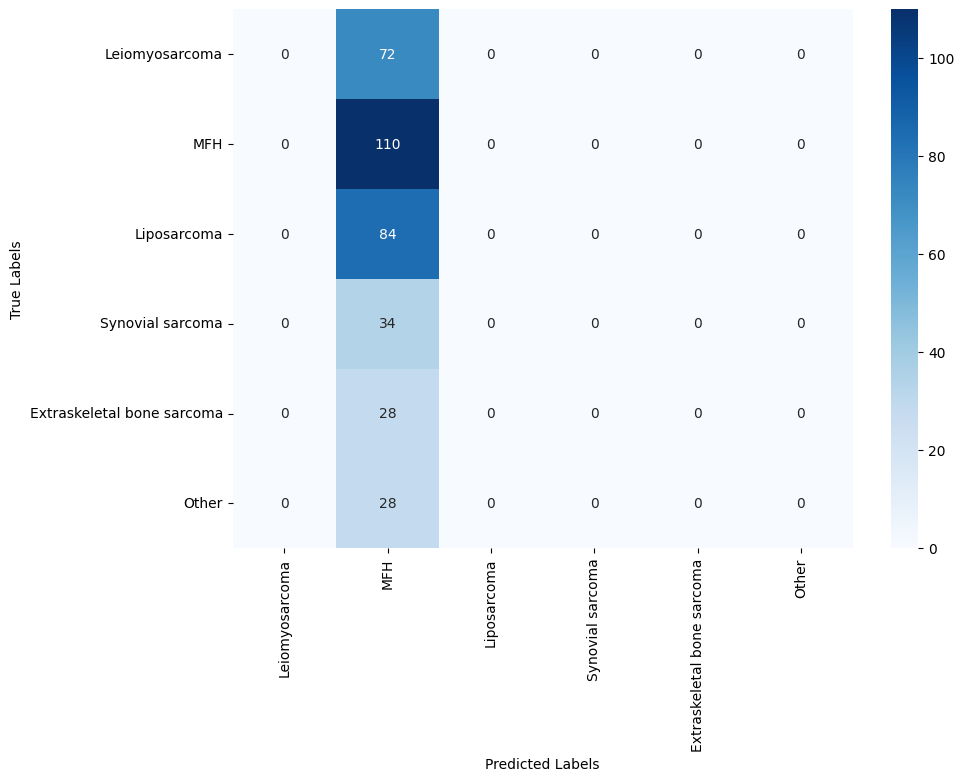

In [84]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

Text(0.5, 1.0, 'Macro Precision')

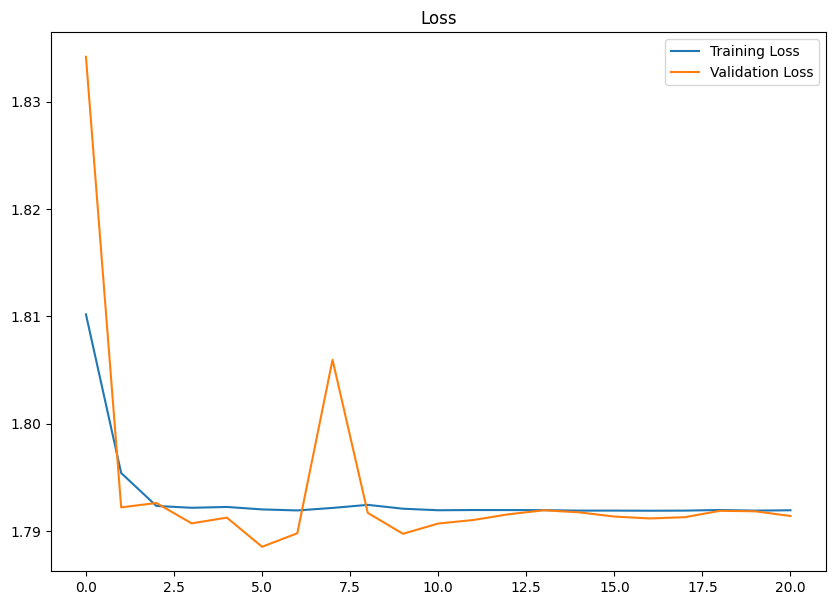

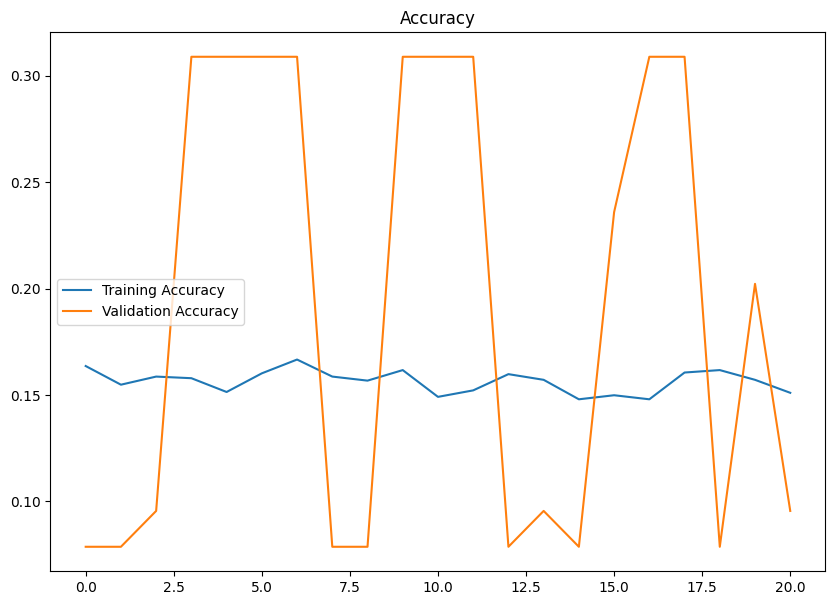

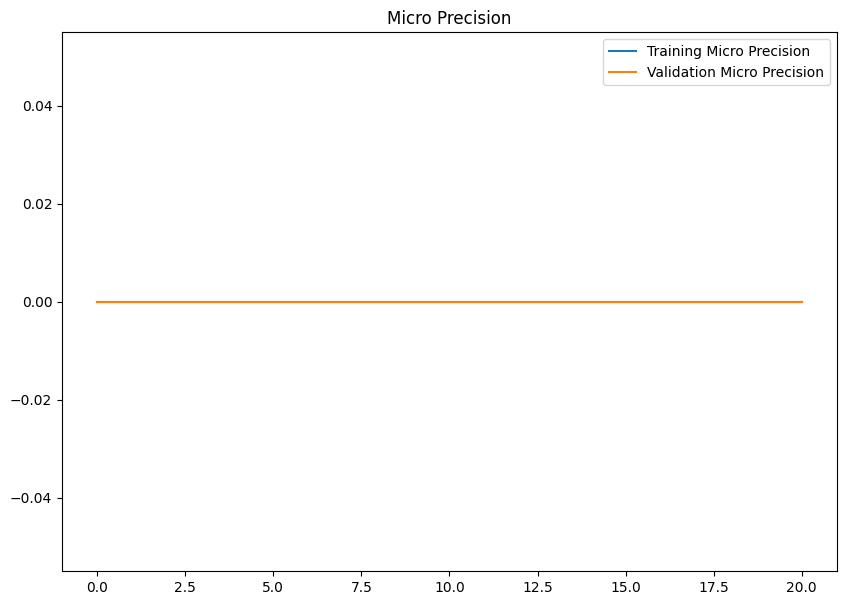

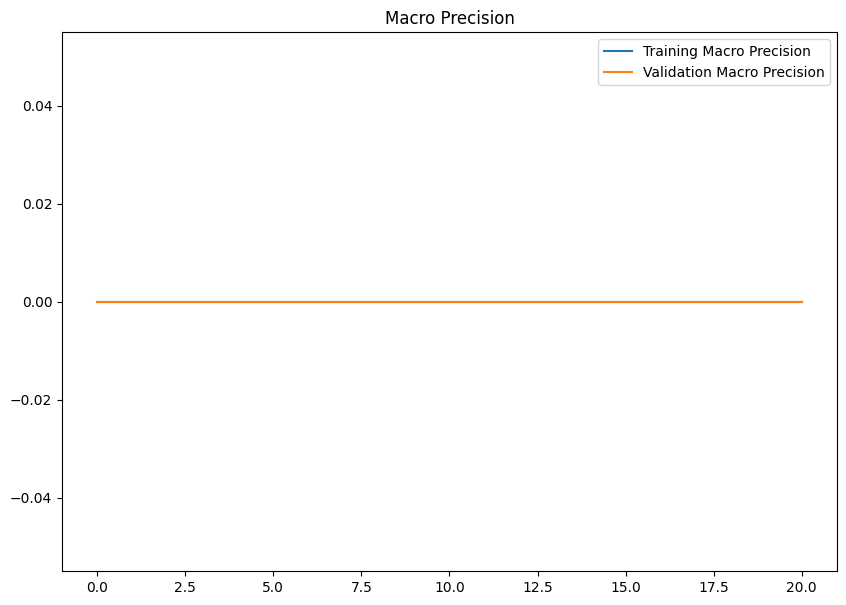

In [85]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Model deem unsuitable for the current dataset, hence no model saving, hyperparameter tuning or cross validation was done

## xception Model

In [53]:
# change batch size back to 32
train_generator.batch_size = 32

# xception model
xception_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# freeze the base model
xception_model.trainable = False

### xception attempt without hyperparameter tuning

#### Model Building

In [54]:
# model sequential
model = tf.keras.Sequential([
    xception_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\xception\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping],
    validation_data=test_generator,
    verbose=1
)

Epoch 1/100
82/82 [==============================] - 25s 286ms/step - loss: 4.4048 - categorical_accuracy: 0.4466 - macroprecision: 0.4529 - microprecision: 0.4522 - val_loss: 2.4062 - val_categorical_accuracy: 0.5112 - val_macroprecision: 0.5239 - val_microprecision: 0.5398
Epoch 2/100
82/82 [==============================] - 23s 284ms/step - loss: 2.2677 - categorical_accuracy: 0.5950 - macroprecision: 0.6155 - microprecision: 0.6058 - val_loss: 2.3352 - val_categorical_accuracy: 0.5955 - val_macroprecision: 0.5564 - val_microprecision: 0.5935
Epoch 3/100
82/82 [==============================] - 23s 275ms/step - loss: 1.9709 - categorical_accuracy: 0.6613 - macroprecision: 0.6910 - microprecision: 0.6657 - val_loss: 2.0801 - val_categorical_accuracy: 0.6461 - val_macroprecision: 0.6217 - val_microprecision: 0.6603
Epoch 4/100
82/82 [==============================] - 22s 274ms/step - loss: 1.7187 - categorical_accuracy: 0.6949 - macroprecision: 0.7127 - microprecision: 0.7020 - val_lo

#### Model classification report

12/12 [==============================] - 1s 52ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.51      0.82      0.63        28
            Leiomyosarcoma       0.82      0.68      0.74        72
               Liposarcoma       0.71      0.75      0.73        84
                       MFH       0.79      0.68      0.73       110
                     Other       0.90      0.96      0.93        28
          Synovial sarcoma       0.57      0.62      0.59        34

                  accuracy                           0.72       356
                 macro avg       0.72      0.75      0.73       356
              weighted avg       0.74      0.72      0.73       356

Macro Precision:  0.7154473663491995
Micro Precision:  0.7247191011235955


Text(95.7222222222222, 0.5, 'True Labels')

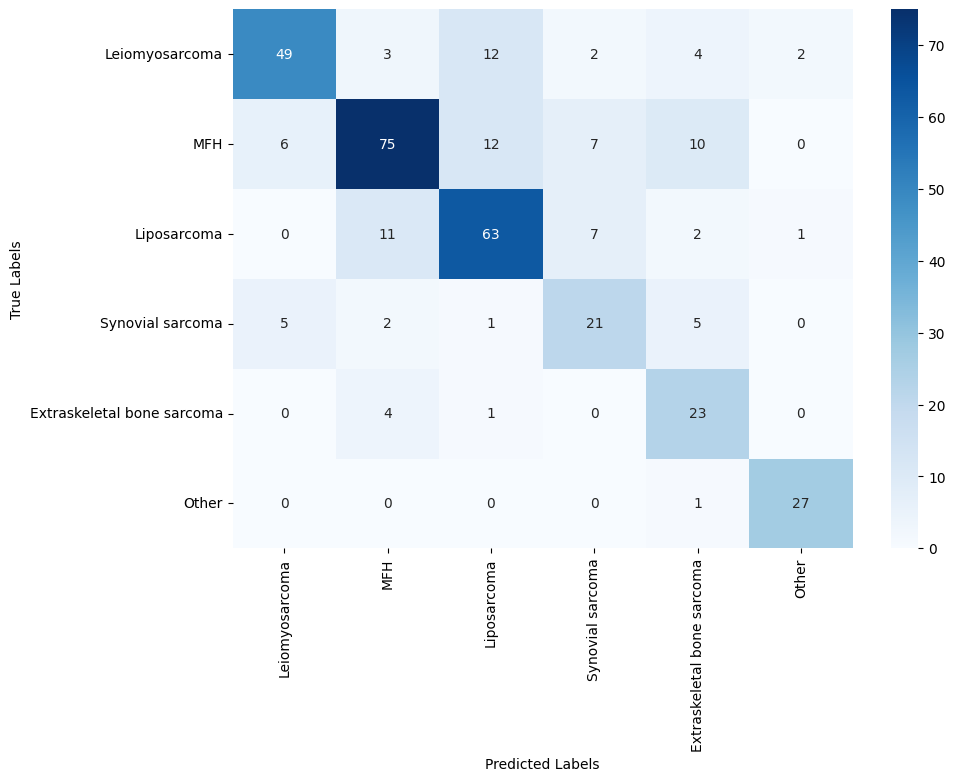

In [55]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

Text(0.5, 1.0, 'Macro Precision')

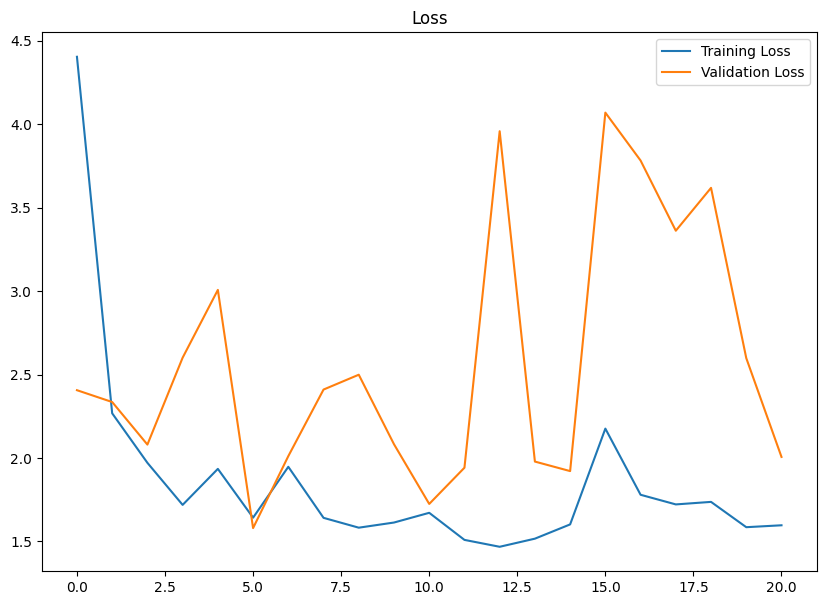

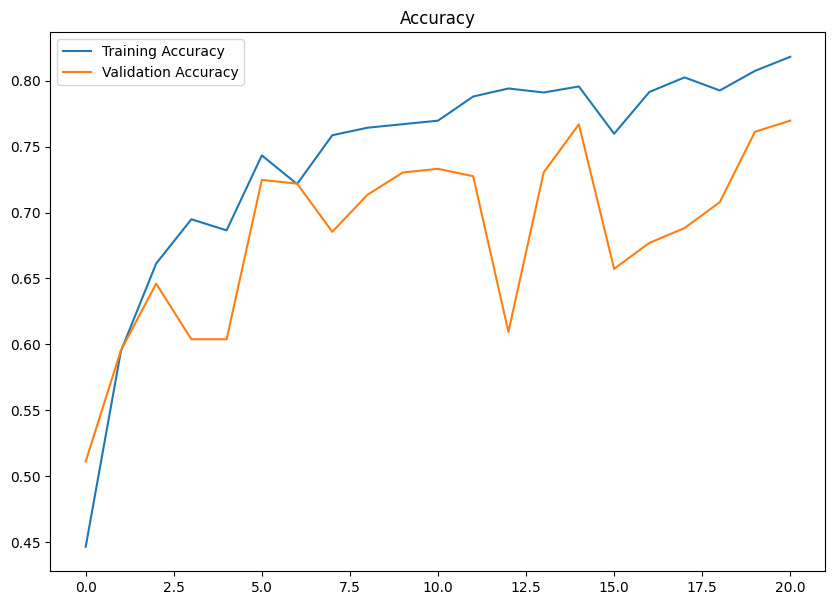

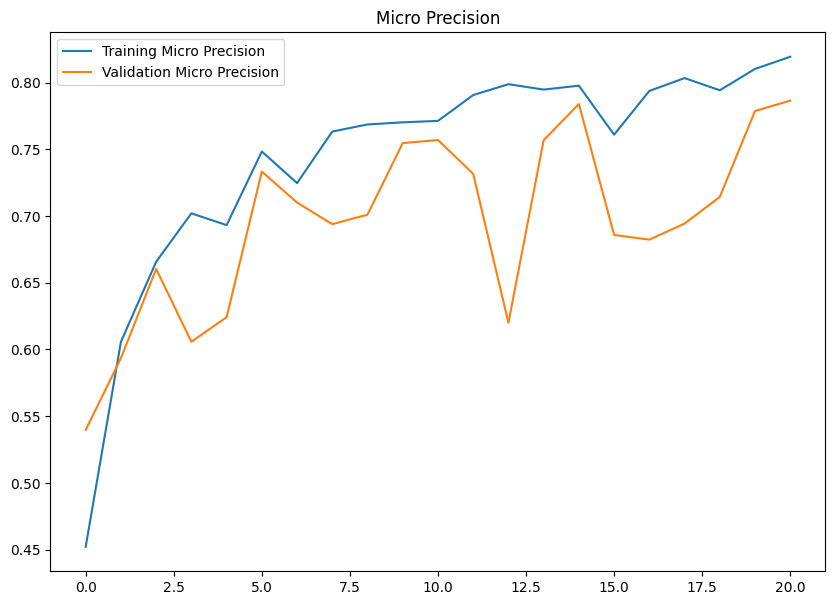

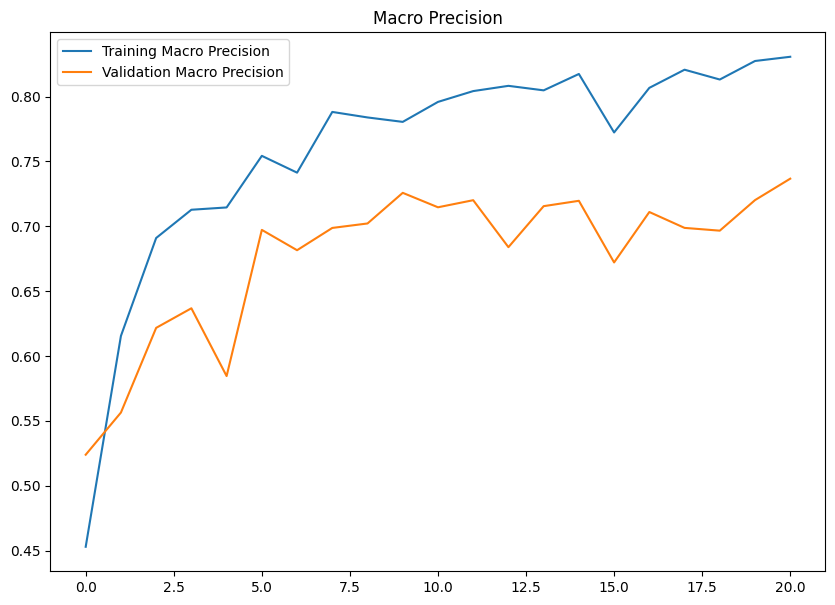

In [56]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [57]:
#  save the model
model.save('models\\xception\\xceptionl-test.h5')

### xception attempt with hyperparameter tuning

#### Define xception model class

In [58]:
class xception_class(HyperModel):
    def build(self, hp):
        xception_model = tf.keras.applications.Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )
        xception_model.trainable = False
        model = tf.keras.models.Sequential([
            xception_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        train_generator.batch_size = hp.Choice("batch_size", [16, 32, 64])
        return model.fit(
            *args,
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [59]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = xception_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite= OVERWRITE_STATUS,
    directory='models\\xception\\random_search',
    project_name='xception'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = test_generator,
    callbacks=[early_stopping],
)

Trial 50 Complete [00h 09m 15s]
val_loss: 2.5518990755081177

Best val_loss So Far: 0.4690251499414444
Total elapsed time: 09h 12m 37s
INFO:tensorflow:Oracle triggered exit


#### Tuning results

In [60]:
tuner.results_summary()

Results summary
Results in models\xception\random_search\xception
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 07 summary
Hyperparameters:
dropout_rate: 0.30000000000000004
learning_rate: 0.0001
batch_size: 64
epochs: 50
Score: 0.4690251499414444

Trial 33 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.0001
batch_size: 64
epochs: 100
Score: 0.4703642576932907

Trial 13 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.0001
batch_size: 32
epochs: 100
Score: 0.48070572316646576

Trial 20 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size: 32
epochs: 50
Score: 0.4859326332807541

Trial 16 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size: 64
epochs: 50
Score: 0.5066465437412262

Trial 42 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.0001
batch_size: 32
epochs: 75
Score: 0.5221532881259918

Trial 27 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size:

In [61]:
tuner.get_best_hyperparameters()[0].values

{'dropout_rate': 0.30000000000000004,
 'learning_rate': 0.0001,
 'batch_size': 64,
 'epochs': 50}

#### Build the model with the best hyperparameters

##### Model Building

In [62]:
# Build the model with the best hyperparameters
xception_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\xception\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

train_generator.batch_size = best_hyperparameters.values['batch_size']
#  fit the model
history = xception_tuned_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs= best_hyperparameters.values['epochs'],
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/50
82/82 [==============================] - 26s 289ms/step - loss: 1.5011 - categorical_accuracy: 0.4397 - macroprecision: 0.4816 - microprecision: 0.5286 - val_loss: 1.3107 - val_categorical_accuracy: 0.4888 - val_macroprecision: 0.6395 - val_microprecision: 0.6594
Epoch 2/50
82/82 [==============================] - 23s 281ms/step - loss: 1.0684 - categorical_accuracy: 0.5904 - macroprecision: 0.6799 - microprecision: 0.7039 - val_loss: 1.2885 - val_categorical_accuracy: 0.5337 - val_macroprecision: 0.6629 - val_microprecision: 0.6333
Epoch 3/50
82/82 [==============================] - 23s 279ms/step - loss: 0.9226 - categorical_accuracy: 0.6640 - macroprecision: 0.7251 - microprecision: 0.7512 - val_loss: 0.9691 - val_categorical_accuracy: 0.6433 - val_macroprecision: 0.7324 - val_microprecision: 0.7498
Epoch 4/50
82/82 [==============================] - 23s 280ms/step - loss: 0.8461 - categorical_accuracy: 0.6838 - macroprecision: 0.7673 - microprecision: 0.7738 - val_loss: 

##### Model Classification Report

12/12 [==============================] - 1s 51ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.51      0.82      0.63        28
            Leiomyosarcoma       0.82      0.68      0.74        72
               Liposarcoma       0.71      0.75      0.73        84
                       MFH       0.79      0.68      0.73       110
                     Other       0.90      0.96      0.93        28
          Synovial sarcoma       0.57      0.62      0.59        34

                  accuracy                           0.72       356
                 macro avg       0.72      0.75      0.73       356
              weighted avg       0.74      0.72      0.73       356

Macro Precision:  0.7154473663491995
Micro Precision:  0.7247191011235955


Text(95.7222222222222, 0.5, 'True Labels')

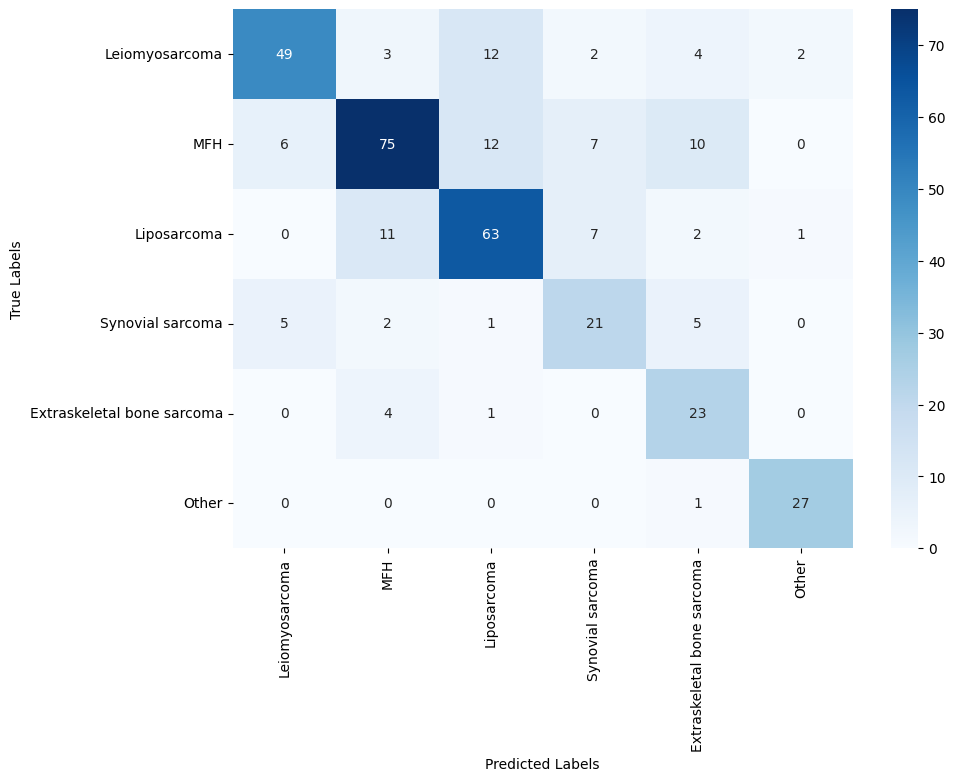

In [63]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

##### model History

Text(0.5, 1.0, 'Macro Precision')

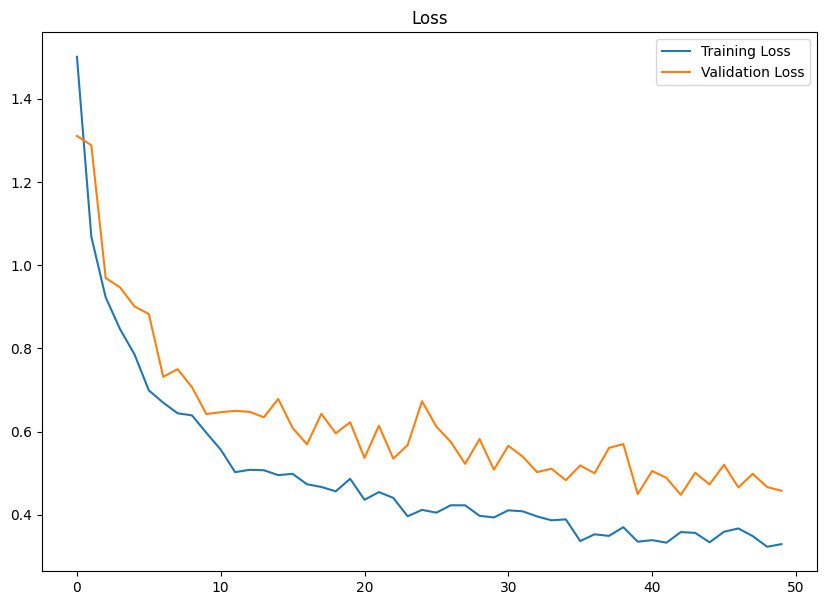

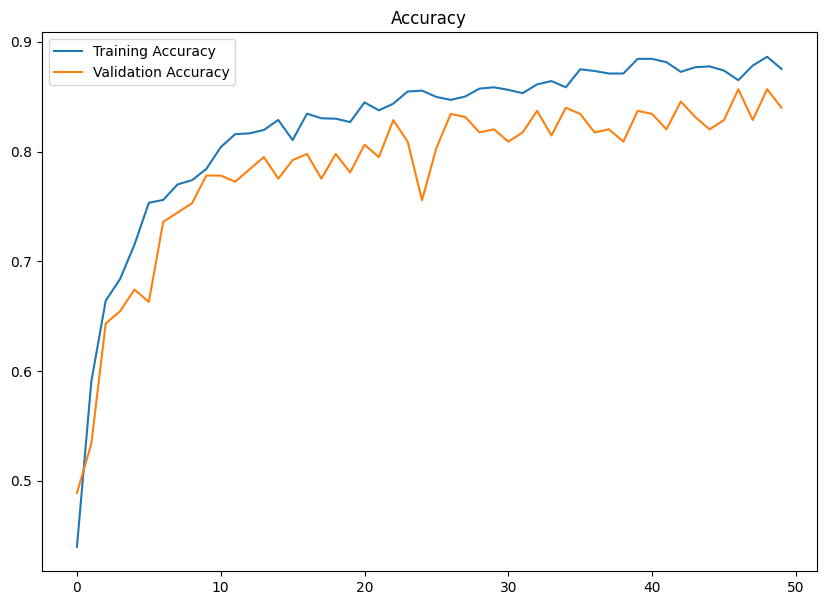

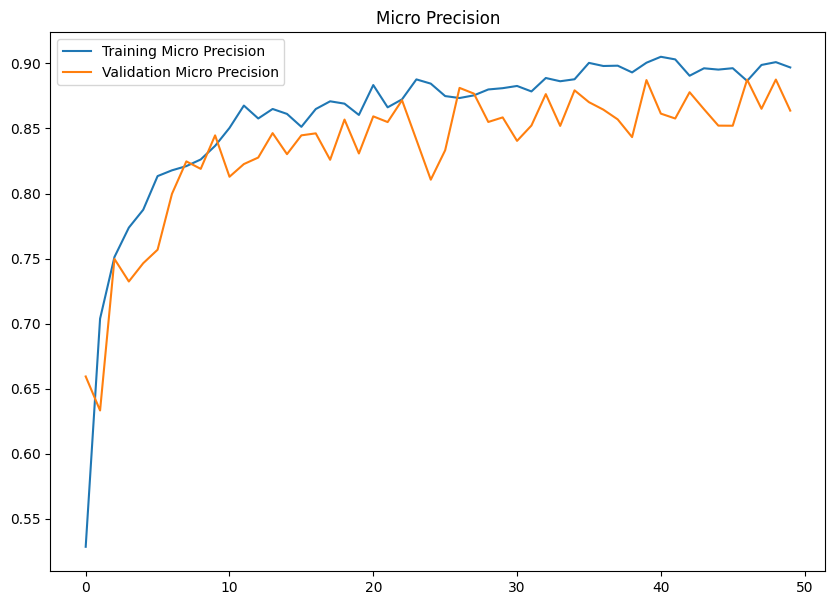

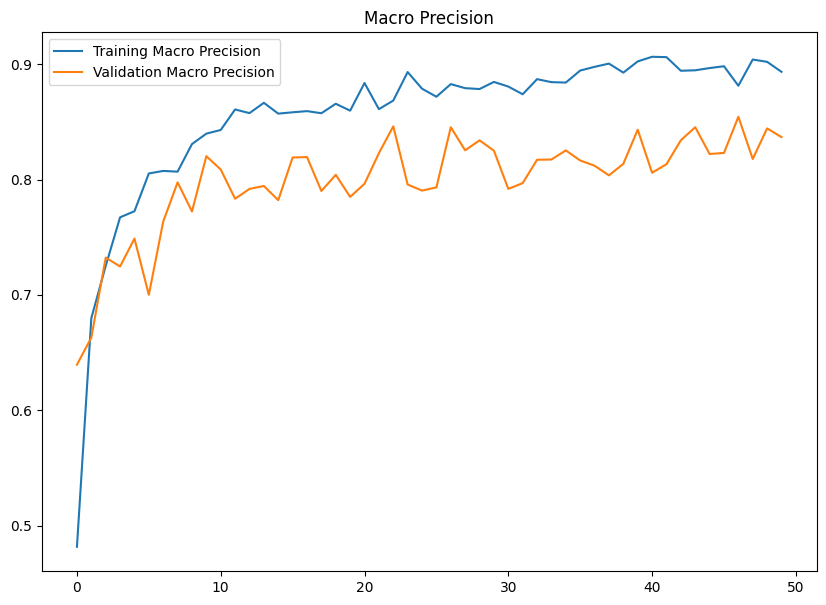

In [64]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [65]:
# save the model
model.save('models\\xception\\xception-tuned-mode.h5')

### xception Cross Validation

In [67]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)

i = 1
xception_hist = []
xception_accuracy = []
xception_micro_precision = []
xception_macro_precision = []
X = train_df['Image Path']
y = train_df['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\xception\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df.iloc[train_index]
    test_data_cv  = train_df.iloc[test_index]
    
    train_data_cv, _ = ros.fit_resample(train_data_cv, train_data_cv['Label'])  
    
    train_generator_cv = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=best_hyperparameters.values['batch_size'],
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator_cv = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    xception_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    xception_hist.append(xception_tuned_model_cv.fit(
        train_generator_cv,
        epochs=best_hyperparameters.values['epochs'],
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator_cv,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    xception_tuned_model_cv.evaluate(test_generator_cv, verbose=0)
    predictions = xception_tuned_model_cv.predict(test_generator_cv, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator_cv.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    xception_accuracy.append(accuracy_score(true_labels, predicted_labels))
    xception_micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    xception_macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', xception_accuracy[i-1], '\nMicro Precision: ', xception_micro_precision[i-1], '\nMacro Precision: ', xception_macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(xception_accuracy))
print('Average micro precision: ', np.mean(xception_micro_precision))
print('Average macro precision: ', np.mean(xception_macro_precision))

--------------------------------------------------
Fold  1
--------------------------------------------------
Found 2100 validated image filenames.
Found 525 validated image filenames.

Model 1 evaluation:
Accuracy:  0.820952380952381 
Micro Precision:  0.820952380952381 
Macro Precision:  0.859225660889778


--------------------------------------------------
Fold  2
--------------------------------------------------
Found 2100 validated image filenames.
Found 525 validated image filenames.

Model 2 evaluation:
Accuracy:  0.8380952380952381 
Micro Precision:  0.8380952380952381 
Macro Precision:  0.8476579827810112


--------------------------------------------------
Fold  3
--------------------------------------------------
Found 2100 validated image filenames.
Found 524 validated image filenames.

Model 3 evaluation:
Accuracy:  0.8702290076335878 
Micro Precision:  0.8702290076335878 
Macro Precision:  0.878527178612098


--------------------------------------------------
Fold  4
---

## DenseNet Model

In [68]:
# change batch size back to 32
train_generator.batch_size = 32

# dense net
#  create the model
dense_net = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

#  freeze the layers
dense_net.trainable = False

### DenseNet attempt without hyperparameter tuning

#### Model Building

In [69]:
#  create the model
model = tf.keras.Sequential([
    dense_net,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(6, activation='softmax')
])

#  compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision]
)

#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PAT,
    restore_best_weights=True
)

# create the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\DenseNet\\model_checkpoint',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

# reset the generators
train_generator.reset()
test_generator.reset()

# fit the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[model_checkpoint, early_stopping]
)

# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/100
82/82 [==============================] - 32s 333ms/step - loss: 4.7178 - categorical_accuracy: 0.4123 - macroprecision: 0.4313 - microprecision: 0.4228 - val_loss: 2.6379 - val_categorical_accuracy: 0.4888 - val_macroprecision: 0.4841 - val_microprecision: 0.4982
Epoch 2/100
82/82 [==============================] - 26s 313ms/step - loss: 2.3295 - categorical_accuracy: 0.5778 - macroprecision: 0.6165 - microprecision: 0.5872 - val_loss: 1.7578 - val_categorical_accuracy: 0.5955 - val_macroprecision: 0.5951 - val_microprecision: 0.5748
Epoch 3/100
82/82 [==============================] - 25s 302ms/step - loss: 1.9858 - categorical_accuracy: 0.6365 - macroprecision: 0.6793 - microprecision: 0.6437 - val_loss: 1.7712 - val_categorical_accuracy: 0.6798 - val_macroprecision: 0.6884 - val_microprecision: 0.6671
Epoch 4/100
82/82 [==============================] - 25s 304ms/step - loss: 2.3933 - categorical_accuracy: 0.6404 - macroprecision: 0.6688 - microprecision: 0.6432 - val_lo

#### Model Classification Report

12/12 [==============================] - 3s 90ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.76      0.89      0.82        28
            Leiomyosarcoma       0.81      0.72      0.76        72
               Liposarcoma       0.77      0.86      0.81        84
                       MFH       0.83      0.77      0.80       110
                     Other       0.79      0.96      0.87        28
          Synovial sarcoma       0.87      0.76      0.81        34

                  accuracy                           0.81       356
                 macro avg       0.81      0.83      0.81       356
              weighted avg       0.81      0.81      0.80       356

Macro Precision:  0.8063978255036129
Micro Precision:  0.8061797752808989


Text(95.7222222222222, 0.5, 'True Labels')

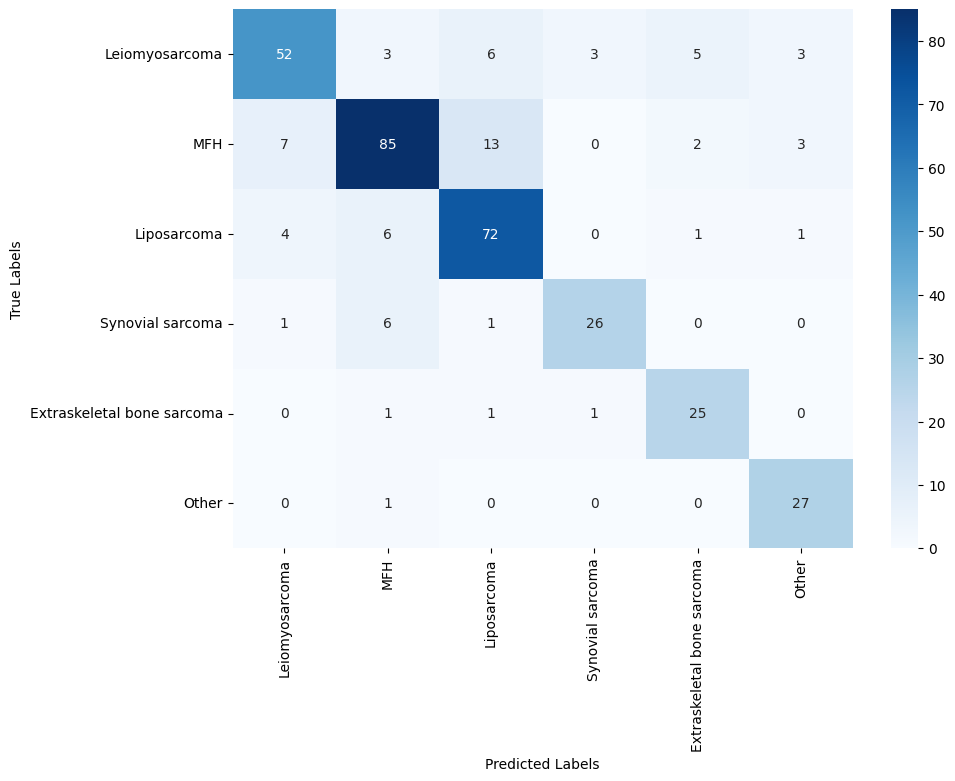

In [70]:
#  evaluate the model
model.evaluate(test_generator)

#  predict the test data
predictions = model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

#### Model History

Text(0.5, 1.0, 'Macro Precision')

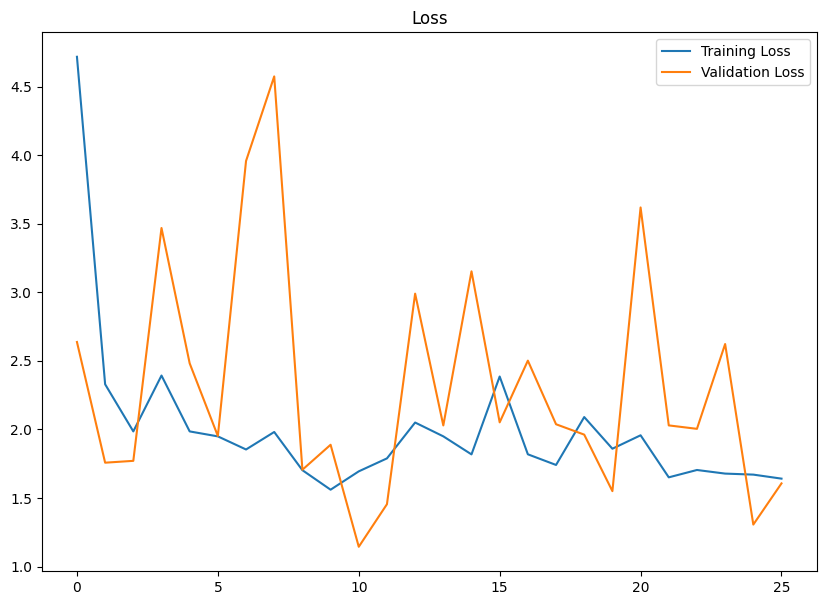

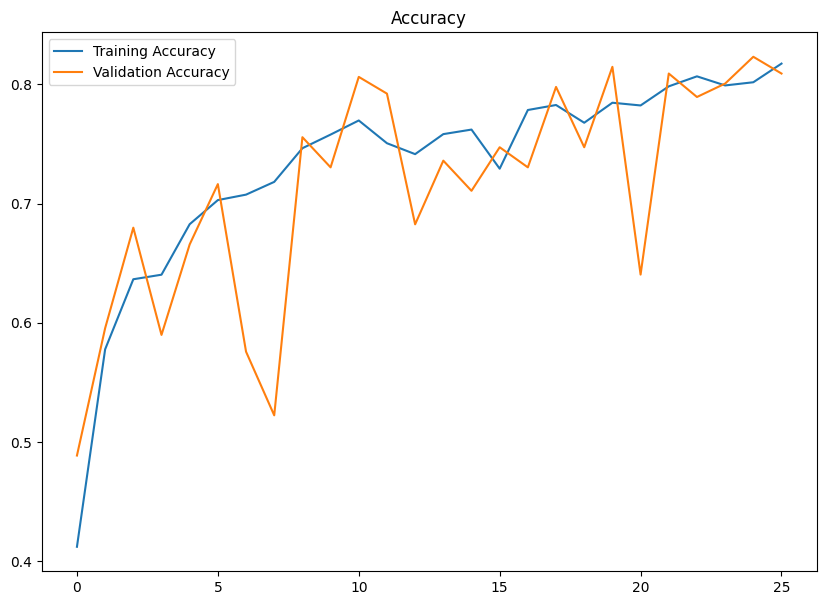

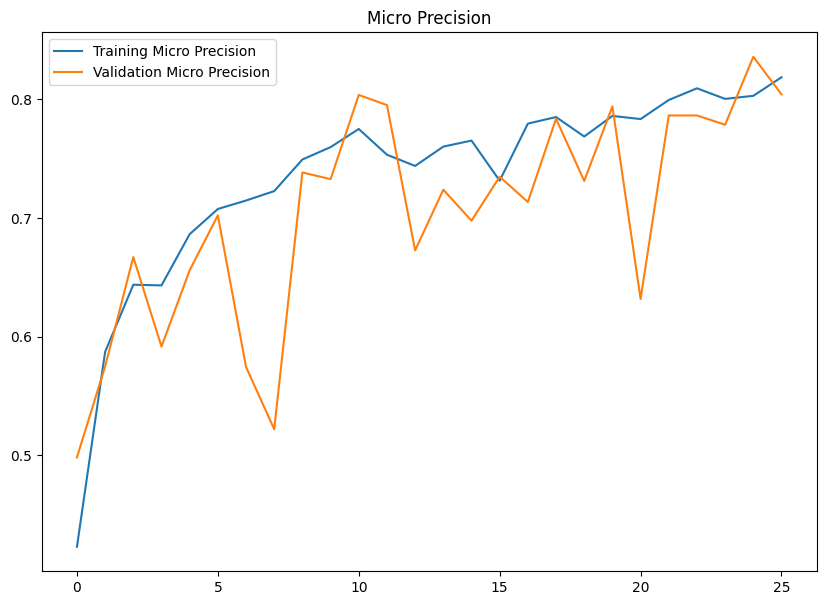

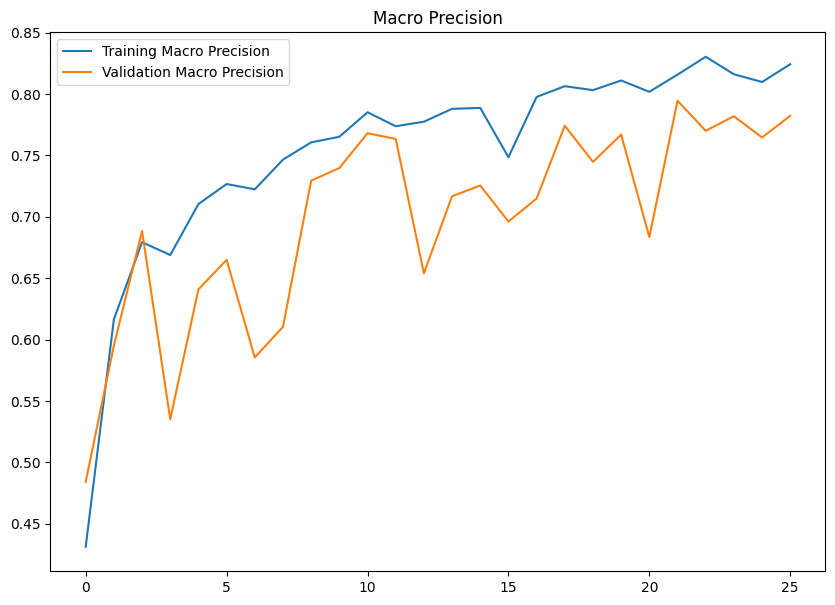

In [71]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

#### Save Model

In [72]:
# save the model
model.save('models\\DenseNet\\DenseNet-model-test.h5')

### DenseNet attempt with hyperparameter tuning

#### Define DenseNet model class

In [73]:
class DenseNet_class(HyperModel):
    def build(self, hp):
        dense_net = tf.keras.applications.DenseNet121(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )
        dense_net.trainable = False
        model = tf.keras.models.Sequential([
            dense_net,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)),
            tf.keras.layers.Dense(6, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, 
                        loss=tf.keras.losses.CategoricalCrossentropy(), 
                        metrics=[tf.keras.metrics.CategoricalAccuracy(), macroprecision, microprecision])
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        train_generator.batch_size = hp.Choice("batch_size", [16, 32, 64])
        return model.fit(
            *args,
            epochs=hp.Choice("epochs", [50, 75, 100]),
            **kwargs,
        )

#### Random search for hyperparameter tuning

In [74]:
#  create the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=TUNING_PAT,
    restore_best_weights=True
)

#  create the tuner
tuner = RandomSearch(
    hypermodel = DenseNet_class(),
    objective='val_loss',
    seed=42,
    max_trials=50,
    executions_per_trial=2,
    overwrite= OVERWRITE_STATUS,
    directory='models\\DenseNet\\random_search',
    project_name='DenseNet'
)

#  search for the best hyperparameters
tuner.search(
    train_generator,
    validation_data = test_generator,
    callbacks=[early_stopping],
)

Trial 50 Complete [00h 12m 11s]
val_loss: 2.0068360567092896

Best val_loss So Far: 0.4148090332746506
Total elapsed time: 09h 46m 57s
INFO:tensorflow:Oracle triggered exit


#### Tuning results

In [75]:
tuner.results_summary()

Results summary
Results in models\DenseNet\random_search\DenseNet
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 13 summary
Hyperparameters:
dropout_rate: 0.2
learning_rate: 0.0001
batch_size: 32
epochs: 100
Score: 0.4148090332746506

Trial 33 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.0001
batch_size: 64
epochs: 100
Score: 0.4568406790494919

Trial 42 summary
Hyperparameters:
dropout_rate: 0.0
learning_rate: 0.0001
batch_size: 32
epochs: 75
Score: 0.467010498046875

Trial 07 summary
Hyperparameters:
dropout_rate: 0.30000000000000004
learning_rate: 0.0001
batch_size: 64
epochs: 50
Score: 0.47118912637233734

Trial 16 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size: 64
epochs: 50
Score: 0.49733901023864746

Trial 09 summary
Hyperparameters:
dropout_rate: 0.1
learning_rate: 0.0001
batch_size: 64
epochs: 50
Score: 0.5088672935962677

Trial 27 summary
Hyperparameters:
dropout_rate: 0.4
learning_rate: 0.0001
batch_size:

In [76]:
#  get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

{'dropout_rate': 0.2, 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 100}

#### Build the model with the best hyperparameters

##### Model Building

In [77]:
# Build the model with the best hyperparameters
densenet_tuned_model = tuner.hypermodel.build(best_hyperparameters)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='tf_checkpoints\\DenseNet\\tuning_model',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=PAT,
    restore_best_weights=True
) 

train_generator.batch_size = best_hyperparameters.values['batch_size']

#  fit the model
history = densenet_tuned_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs = best_hyperparameters.values['epochs'],
    callbacks=[model_checkpoint, early_stopping]
)
# reset the generators
train_generator.reset()
test_generator.reset()

Epoch 1/100
82/82 [==============================] - 29s 309ms/step - loss: 1.9724 - categorical_accuracy: 0.3535 - macroprecision: 0.3547 - microprecision: 0.3802 - val_loss: 1.6956 - val_categorical_accuracy: 0.3652 - val_macroprecision: 0.3717 - val_microprecision: 0.4053
Epoch 2/100
82/82 [==============================] - 24s 292ms/step - loss: 1.4266 - categorical_accuracy: 0.5027 - macroprecision: 0.5510 - microprecision: 0.5633 - val_loss: 1.4109 - val_categorical_accuracy: 0.4803 - val_macroprecision: 0.5451 - val_microprecision: 0.5752
Epoch 3/100
82/82 [==============================] - 24s 292ms/step - loss: 1.2231 - categorical_accuracy: 0.5606 - macroprecision: 0.6247 - microprecision: 0.6276 - val_loss: 1.0770 - val_categorical_accuracy: 0.5955 - val_macroprecision: 0.6987 - val_microprecision: 0.6751
Epoch 4/100
82/82 [==============================] - 23s 285ms/step - loss: 1.0861 - categorical_accuracy: 0.6110 - macroprecision: 0.6466 - microprecision: 0.6626 - val_lo

##### Model Classification Report

12/12 [==============================] - 2s 68ms/step
                            precision    recall  f1-score   support

Extraskeletal bone sarcoma       0.96      0.93      0.95        28
            Leiomyosarcoma       0.80      0.92      0.86        72
               Liposarcoma       0.88      0.94      0.91        84
                       MFH       0.96      0.78      0.86       110
                     Other       0.97      1.00      0.98        28
          Synovial sarcoma       0.82      0.91      0.86        34

                  accuracy                           0.89       356
                 macro avg       0.90      0.91      0.90       356
              weighted avg       0.89      0.89      0.89       356

Macro Precision:  0.8970801766900509
Micro Precision:  0.8876404494382022


Text(95.7222222222222, 0.5, 'True Labels')

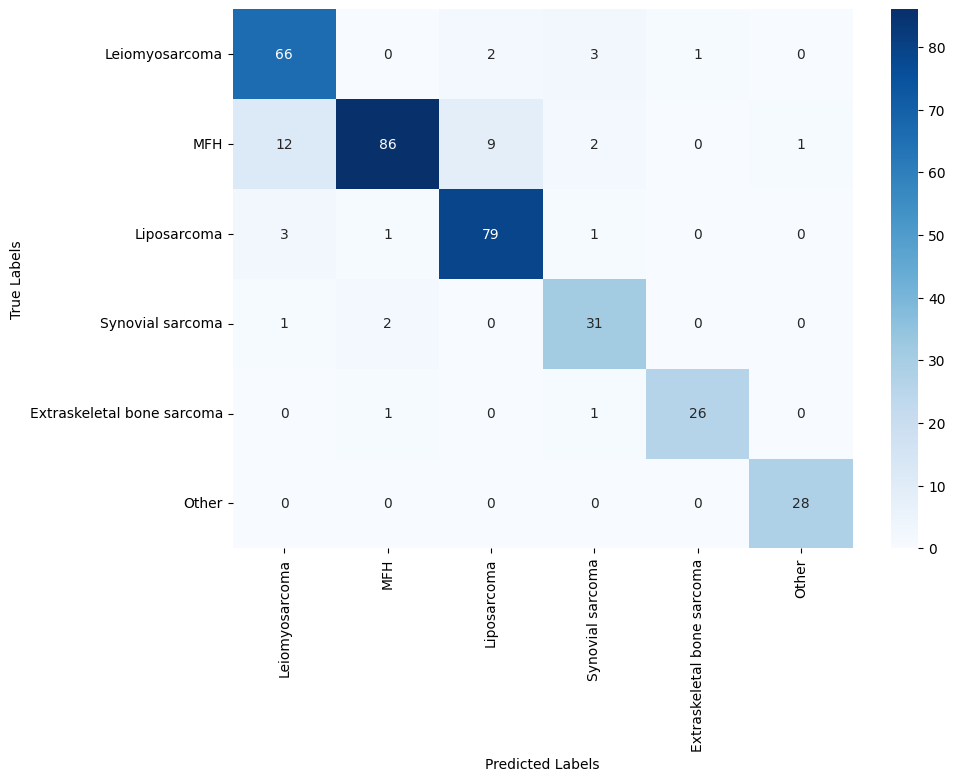

In [78]:
#  evaluate the model
densenet_tuned_model.evaluate(test_generator)

#  predict the test data
predictions = densenet_tuned_model.predict(test_generator)

#  get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

#  get the true labels
true_labels = test_generator.labels

# change the true_labels to the original labels
true_labels = np.argmax(true_labels, axis=1)

predicted_labels =  change_labels(predicted_labels, y_columns)
true_labels = change_labels(true_labels, y_columns)

#  print the classification report
print(classification_report(true_labels, predicted_labels))

#  print macro precision
micro_precision = precision_score(true_labels, predicted_labels, average='macro')
print('Macro Precision: ', micro_precision)

#  print micro precision
micro_precision = precision_score(true_labels, predicted_labels, average='micro')
print('Micro Precision: ', micro_precision)

#  get the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=y_columns)

#  plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_columns, yticklabels=y_columns)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

##### Model History

Text(0.5, 1.0, 'Macro Precision')

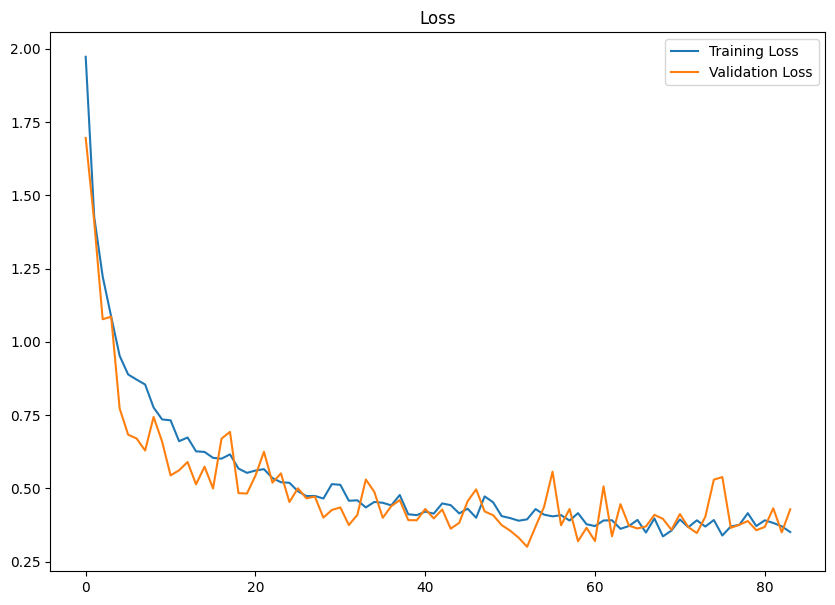

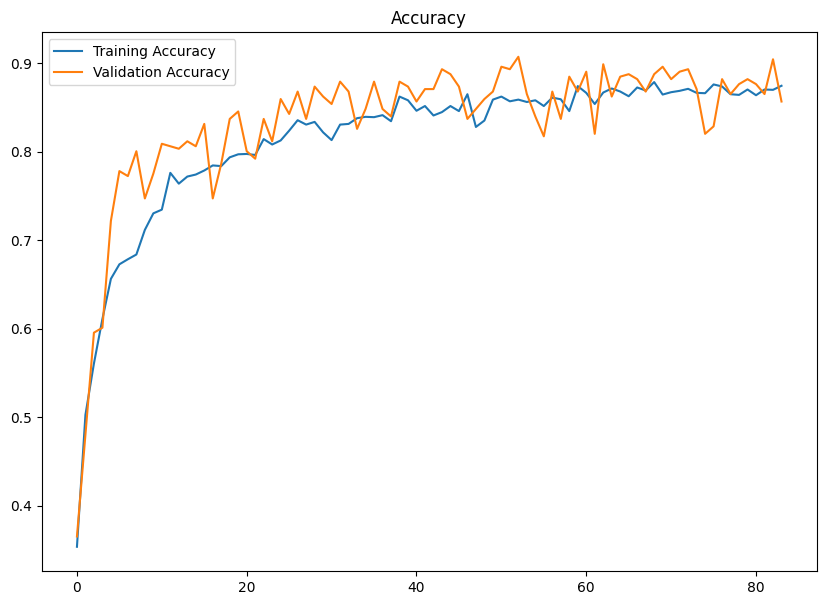

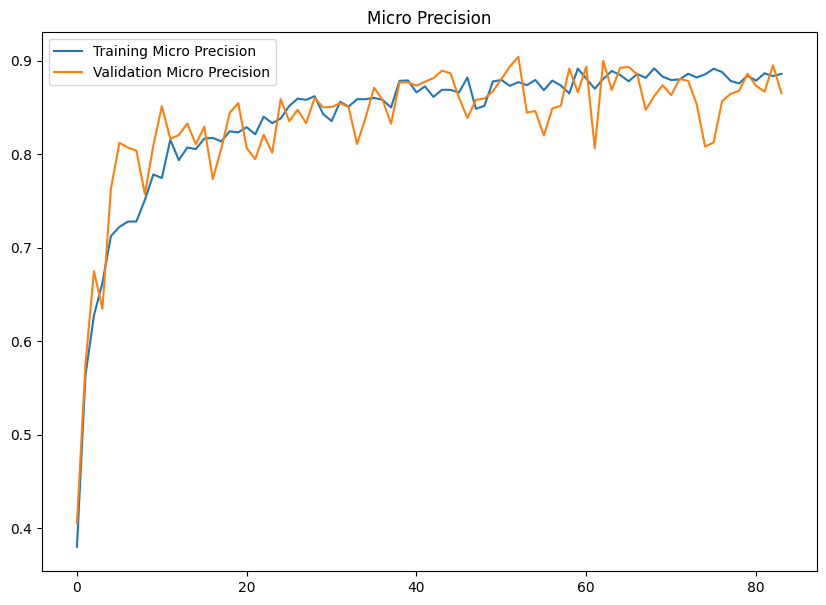

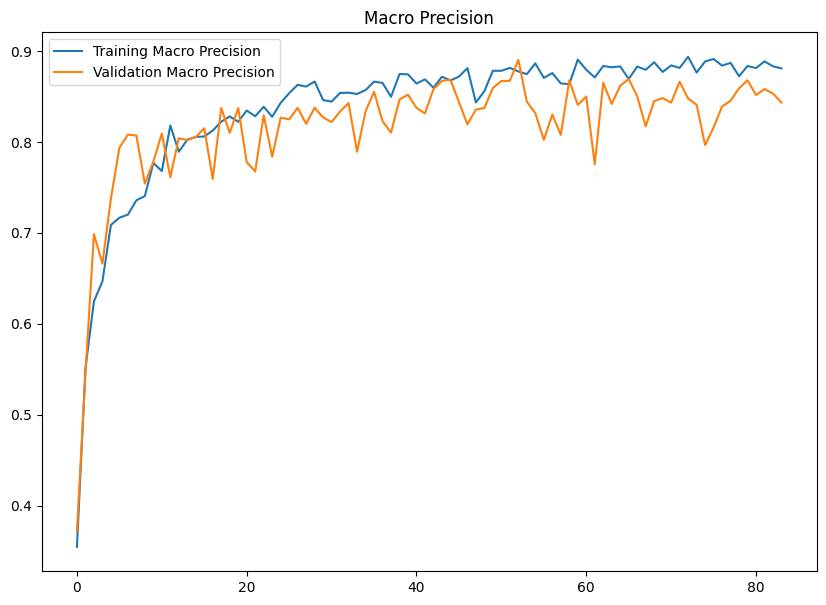

In [79]:
#  plot the loss and accuracy
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.figure(figsize=(10, 7))
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.figure(figsize=(10, 7))
plt.plot(history.history['microprecision'], label='Training Micro Precision')
plt.plot(history.history['val_microprecision'], label='Validation Micro Precision')
plt.legend()
plt.title('Micro Precision')

plt.figure(figsize=(10, 7))
plt.plot(history.history['macroprecision'], label='Training Macro Precision')
plt.plot(history.history['val_macroprecision'], label='Validation Macro Precision')
plt.legend()
plt.title('Macro Precision')

##### Save Model

In [80]:
# save the model
densenet_tuned_model.save('models\\DenseNet\\DenseNet-model-tuned.h5')

### DenseNet Cross Validation

In [81]:
# cross validation
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)

i = 1
densenet_hist = []
densenet_accuracy = []
densenet_micro_precision = []
densenet_macro_precision = []
X = train_df['Image Path']
y = train_df['Label']

for train_index, test_index in skf.split(X, y):
    if i != 1:
        print('\n')
    print('-'*50)
    print('Fold ', i)
    print('-'*50)
    model_checkpoint_cv = tf.keras.callbacks.ModelCheckpoint(
        filepath='tf_checkpoints\\DenseNet\\cv_model\\model_' + str(i),
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=PAT,
        restore_best_weights=True
    ) 
    
    train_data_cv  = train_df.iloc[train_index]
    test_data_cv  = train_df.iloc[test_index]
    
    train_data_cv, _ = ros.fit_resample(train_data_cv, train_data_cv['Label'])  
    
    train_generator_cv = train_datagen.flow_from_dataframe(
        dataframe=train_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=best_hyperparameters.values['batch_size'],
        class_mode='raw',
        shuffle=True,
        seed=42,
        verbose=0
    )

    test_generator_cv = test_datagen.flow_from_dataframe(
        dataframe=test_data_cv,
        x_col='Image Path',
        y_col= y_columns,
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        verbose=0
    )

    densenet_tuned_model_cv = tuner.hypermodel.build(best_hyperparameters)

    densenet_hist.append(densenet_tuned_model_cv.fit(
        train_generator_cv,
        epochs=best_hyperparameters.values['epochs'],
        callbacks=[model_checkpoint, early_stopping],
        validation_data=test_generator_cv,
        verbose=0
    ))

    print('\nModel ' + str(i) + ' evaluation:')
    densenet_tuned_model_cv.evaluate(test_generator_cv, verbose=0)
    predictions = densenet_tuned_model_cv.predict(test_generator_cv, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator_cv.labels
    true_labels = np.argmax(true_labels, axis=1)
    predicted_labels =  change_labels(predicted_labels, y_columns)
    true_labels = change_labels(true_labels, y_columns)
    #  record the metrics
    densenet_accuracy.append(accuracy_score(true_labels, predicted_labels))
    densenet_micro_precision.append(precision_score(true_labels, predicted_labels, average='micro'))
    densenet_macro_precision.append(precision_score(true_labels, predicted_labels, average='macro'))
    print('Accuracy: ', densenet_accuracy[i-1], '\nMicro Precision: ', densenet_micro_precision[i-1], '\nMacro Precision: ', densenet_macro_precision[i-1])
    i += 1

print('\n')
print('-'*50)
print('Results:')
print('Average accuracy: ', np.mean(densenet_accuracy))
print('Average micro precision: ', np.mean(densenet_micro_precision))
print('Average macro precision: ', np.mean(densenet_macro_precision))

--------------------------------------------------
Fold  1
--------------------------------------------------
Found 2100 validated image filenames.
Found 525 validated image filenames.

Model 1 evaluation:
Accuracy:  0.8990476190476191 
Micro Precision:  0.8990476190476191 
Macro Precision:  0.9039300010818998


--------------------------------------------------
Fold  2
--------------------------------------------------
Found 2100 validated image filenames.
Found 525 validated image filenames.

Model 2 evaluation:
Accuracy:  0.9180952380952381 
Micro Precision:  0.9180952380952381 
Macro Precision:  0.9227930253369024


--------------------------------------------------
Fold  3
--------------------------------------------------
Found 2100 validated image filenames.
Found 524 validated image filenames.

Model 3 evaluation:
Accuracy:  0.8893129770992366 
Micro Precision:  0.8893129770992366 
Macro Precision:  0.8978306426308391


--------------------------------------------------
Fold  4

# END